# First trys

  Entidad      Relacion            Valor
0   Tango   instance of      music genre
1   Tango  instancia de      music genre
2   Tango   instance of   g√©nero musical
3   Tango  instancia de   g√©nero musical
4   Tango   subclass of  m√∫sica tropical
Grafo creado con 16 nodos y 15 aristas.


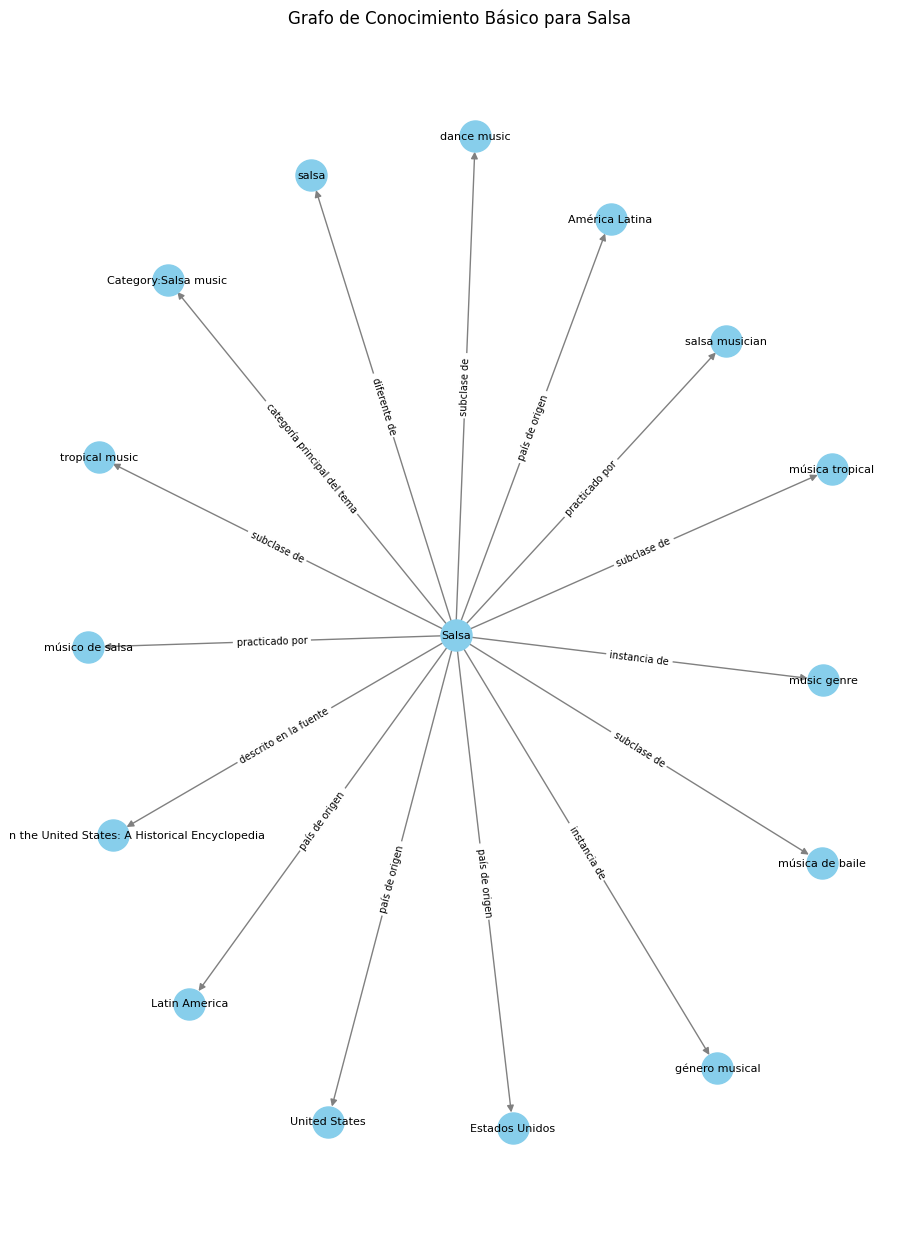

In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt # Para visualizaci√≥n b√°sica

# --- 1. Consulta a Wikidata ---
endpoint_url = "https://query.wikidata.org/sparql"

# Ejemplo: Propiedades directas del Tango (Q9799)
query = """
SELECT ?propUrl ?propLabel ?valueUrl ?valueLabel WHERE {
  wd:Q208239 ?propUrl ?valueUrl .
  ?propInstance wikibase:directClaim ?propUrl . # Obtener la propiedad directa
  ?propInstance rdfs:label ?propLabel .
  ?valueUrl rdfs:label ?valueLabel .
  FILTER(LANG(?propLabel) = "es" || LANG(?propLabel) = "en")
  FILTER(LANG(?valueLabel) = "es" || LANG(?valueLabel) = "en")
} LIMIT 50
"""

def get_sparql_results(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_sparql_results(endpoint_url, query)

# --- 2. Procesar Datos y Construir Grafo ---
triplets = []
for result in results["results"]["bindings"]:
    prop_label = result.get('propLabel', {}).get('value')
    value_label = result.get('valueLabel', {}).get('value')
    # Simple filtro para asegurar que tenemos datos
    if prop_label and value_label:
        triplets.append({"Entidad": "Tango", "Relacion": prop_label, "Valor": value_label})

df_triplets = pd.DataFrame(triplets)
# Limpieza adicional podr√≠a ser necesaria aqu√≠ (eliminar duplicados, etc.)
print(df_triplets.head())

G = nx.DiGraph()
entity_node = "Salsa"
G.add_node(entity_node) # Nodo central

for index, row in df_triplets.iterrows():
    value_node = row['Valor']
    relation_label = row['Relacion']
    G.add_node(value_node)
    G.add_edge(entity_node, value_node, label=relation_label) # A√±adir arista con etiqueta

print(f"Grafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 3. Almacenar y Visualizar (Ejemplo B√°sico) ---

# Almacenar (ejemplo como lista de aristas)
# nx.write_edgelist(G, "tango_kg.csv", delimiter=",", data=['label'])
# print("Grafo guardado como tango_kg.csv")

# Visualizar (muy b√°sico, puede ser ca√≥tico para grafos grandes)
plt.figure(figsize=(9, 12))
pos = nx.spring_layout(G, k=0.9) # Algoritmo de posicionamiento
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8, edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Grafo de Conocimiento B√°sico para Salsa")
plt.show()

# (Alternativa de visualizaci√≥n m√°s interactiva abajo)

In [7]:
# Ejemplo con pyvis (instalar con: pip install pyvis)
from pyvis.network import Network

net = Network(notebook=True, directed=True, cdn_resources='remote') # 'remote' usa JS de internet, 'inline' lo incrusta
net.from_nx(G) # Cargar desde el grafo networkx

# Extraer etiquetas de las aristas para mostrarlas
edge_data = zip(G.edges(data=True), G.edges())
for e, edge_key in edge_data:
    # e es una tupla (nodo_origen, nodo_destino, datos_arista)
    src = e[0]
    dst = e[1]
    data = e[2]
    if 'label' in data:
        edge_info = net.get_edge(edge_key) # pyvis puede asignar ID diferente
        if edge_info: # Asegurarse que la arista existe en pyvis
             net.get_edge(edge_info['id'])['title'] = data['label'] # Mostrar etiqueta al pasar el mouse

net.show_buttons(filter_=['physics']) # A√±adir controles
net.show("tango_kg_interactive.html")
print("Grafo interactivo guardado como tango_kg_interactive.html")

AttributeError: 'Network' object has no attribute 'get_edge'

In [8]:
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
# ... (resto de tu c√≥digo de importaci√≥n y la funci√≥n find_wikidata_qid)

endpoint_url = "https://query.wikidata.org/sparql"

def find_wikidata_qid(entity_label, entity_type_qid=None, lang="es"):
    # ... (c√≥digo de la funci√≥n como antes) ...
    try:
        results = sparql.query().convert()
    except Exception as e: # Captura gen√©rica para simplificar, idealmente m√°s espec√≠fica
        print(f"Error al consultar Wikidata para '{entity_label}': {e}")
        return [] # Devuelve lista vac√≠a en caso de error
    # ... (resto del procesamiento de resultados) ...
    return qids

# --- Lista de entidades a buscar ---
entidades_a_buscar = [
    {"label": "Salsa", "type_qid": "Q188451"},
    {"label": "Mercedes Sosa", "type_qid": "Q177220"}, # Asumiendo Q177220 es cantante
    {"label": "Buenos Aires", "type_qid": "Q5119"},
    {"label": "Tango", "type_qid": "Q188451"}, # A√±adido Tango
    # ... a√±ade m√°s entidades aqu√≠ ...
]

all_results = {}
for entidad in entidades_a_buscar:
    print(f"Buscando QID para: {entidad['label']} (Tipo: {entidad.get('type_qid', 'N/A')})...")
    qids_encontrados = find_wikidata_qid(entidad['label'], entidad.get('type_qid'))
    all_results[entidad['label']] = qids_encontrados
    print(pd.DataFrame(qids_encontrados))
    print("-" * 30)
    # --- PAUSA A√ëADIDA ---
    print("Esperando 1 segundo antes de la siguiente consulta...")
    time.sleep(1) # Espera 1 segundo. Ajusta este valor si sigues recibiendo 429.

# Ahora all_results contiene los QIDs encontrados para cada entidad
# Puedes proceder a usar estos QIDs para construir los grafos

Buscando QID para: Salsa (Tipo: Q188451)...
Error al consultar Wikidata para 'Salsa': name 'sparql' is not defined
Empty DataFrame
Columns: []
Index: []
------------------------------
Esperando 1 segundo antes de la siguiente consulta...
Buscando QID para: Mercedes Sosa (Tipo: Q177220)...
Error al consultar Wikidata para 'Mercedes Sosa': name 'sparql' is not defined
Empty DataFrame
Columns: []
Index: []
------------------------------
Esperando 1 segundo antes de la siguiente consulta...
Buscando QID para: Buenos Aires (Tipo: Q5119)...
Error al consultar Wikidata para 'Buenos Aires': name 'sparql' is not defined
Empty DataFrame
Columns: []
Index: []
------------------------------
Esperando 1 segundo antes de la siguiente consulta...
Buscando QID para: Tango (Tipo: Q188451)...
Error al consultar Wikidata para 'Tango': name 'sparql' is not defined
Empty DataFrame
Columns: []
Index: []
------------------------------
Esperando 1 segundo antes de la siguiente consulta...


# Veamos ahora para automatizar y sacar m√°s identidades

Encontradas 60 entidades (cultura urbana Colombia).
Guardado: GC_cantantes_de_colombia.json


C:\Users\tomas\AppData\Local\Temp\ipykernel_45880\2087420331.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


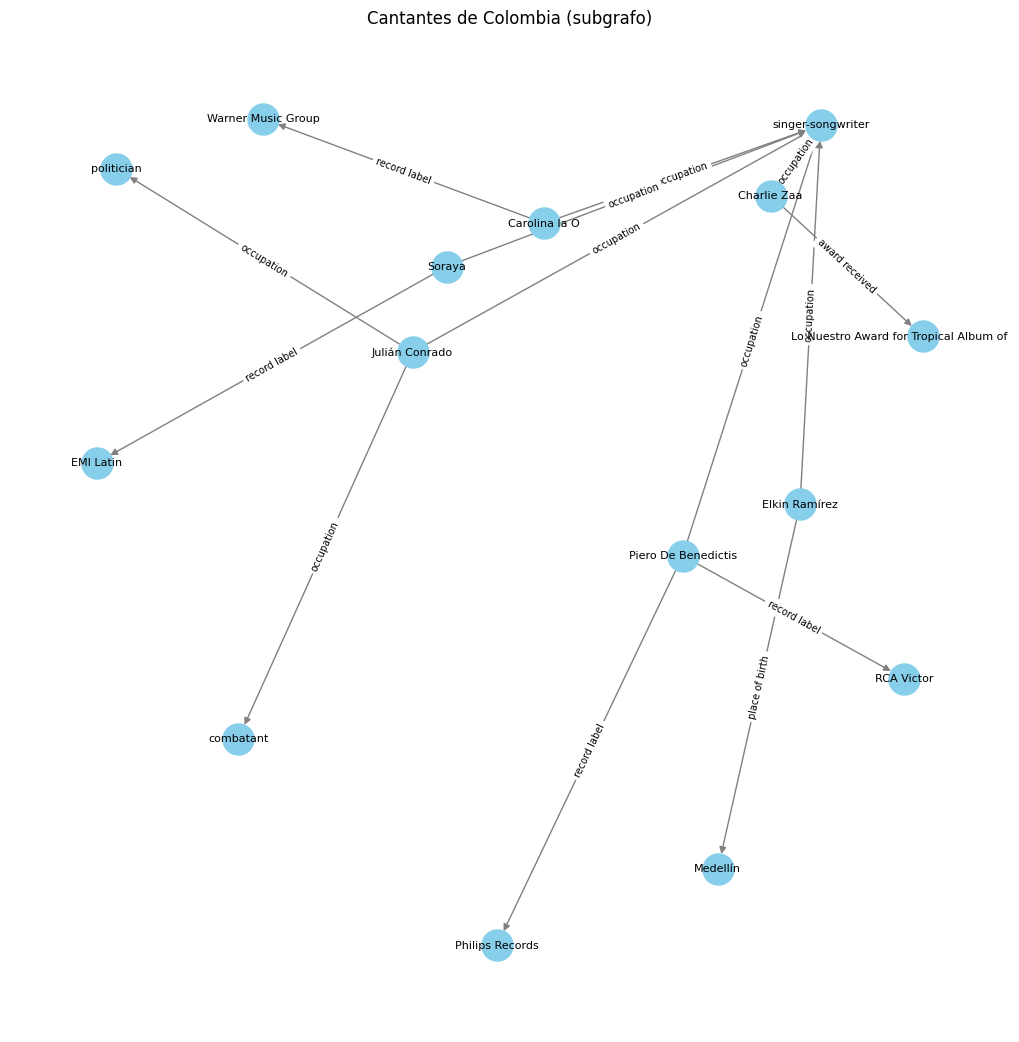

In [1]:
# -*- coding: utf-8 -*-
"""
Wikidata Cultural KG Builder
Autor: T√∫ (hola, Tomniko!)
Requisitos: pip install SPARQLWrapper pandas networkx matplotlib
"""

from SPARQLWrapper import SPARQLWrapper, JSON
import json
import time
from typing import Dict, List, Tuple, Optional
import networkx as nx
import matplotlib.pyplot as plt

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "en,es"  # orden de preferencia para etiquetas

# ----------------------------
# Utilidades SPARQL / Wikidata
# ----------------------------

def _sparql(query: str, *, endpoint: str = WIKIDATA_ENDPOINT, throttle_s: float = 0.75) -> dict:
    """Ejecuta una consulta SPARQL y devuelve el JSON ya convertido."""
    s = SPARQLWrapper(endpoint)
    s.setQuery(query)
    s.setReturnFormat(JSON)
    res = s.query().convert()
    # throttle ligero para ser buen ciudadano con el endpoint
    if throttle_s > 0:
        time.sleep(throttle_s)
    return res

def _values_block(var: str, qids: List[str]) -> str:
    """Genera un bloque VALUES para SPARQL, p.ej. VALUES ?x { wd:Q298 wd:Q30 }"""
    qids_norm = [qid if qid.startswith("Q") else qid for qid in qids]
    wd_terms = " ".join(f"wd:{q}" for q in qids_norm)
    return f"VALUES {var} {{ {wd_terms} }}"

def _property_path(prop_qid: str) -> str:
    """
    Devuelve el identificador 'wdt:Pxxx' a partir del QID de la propiedad Pxxx.
    Puedes pasar ya 'P27' y devolver√° 'wdt:P27'.
    """
    p = prop_qid if prop_qid.startswith("P") else prop_qid
    return f"wdt:{p}"

def _label_service() -> str:
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# ---------------------------------------------
# 1) B√∫squeda de entidades por filtros (gen√©rico)
# ---------------------------------------------

def search_entities_by_filters(
    country_qids: List[str],
    filters: Dict[str, List[str]],
    limit: int = 200,
    offset: int = 0
) -> List[Tuple[str, str]]:
    """
    Busca entidades que cumplan:
      - (al menos uno) de los pa√≠ses en country_qids (t√≠picamente P27: pa√≠s de ciudadan√≠a,
        pero esto se pasa en 'filters' para flexibilidad),
      - y adem√°s TODOS los filtros dados (cada filtro es PROP_Pxxx -> [QIDs]).
    Retorna lista de (item_qid, item_label).
    NOTA: Este m√©todo es flexible: incluye el pa√≠s como un filtro m√°s (ej: {'P27': ['Q298']}).
    """
    # combinamos pa√≠s dentro de filters si no vino ya
    filters = dict(filters)  # copia
    if "P27" not in filters and country_qids:
        filters["P27"] = country_qids

    # Construimos cl√°usulas VALUES por cada propiedad
    values_blocks = []
    where_blocks = []
    i = 0
    for p, vals in filters.items():
        i += 1
        var_obj = f"?v{i}"
        values_blocks.append(_values_block(var_obj, vals))
        where_blocks.append(f"?item {_property_path(p)} {var_obj} .")

    query = f"""
    SELECT DISTINCT ?item ?itemLabel WHERE {{
      {' '.join(values_blocks)}
      {' '.join(where_blocks)}
      {_label_service()}
    }}
    LIMIT {limit}
    OFFSET {offset}
    """.strip()

    data = _sparql(query)
    out = []
    for b in data["results"]["bindings"]:
        qid = b["item"]["value"].split("/")[-1]
        label = b.get("itemLabel", {}).get("value", qid)
        out.append((qid, label))
    return out

def paginate_search(
    country_qids: List[str],
    filters: Dict[str, List[str]],
    max_entities: int = 300
) -> List[Tuple[str, str]]:
    """Pagina la b√∫squeda para traer hasta max_entities."""
    all_items = []
    batch = 200
    offset = 0
    while len(all_items) < max_entities:
        rows = search_entities_by_filters(country_qids, filters, limit=min(batch, max_entities - len(all_items)), offset=offset)
        if not rows:
            break
        all_items.extend(rows)
        offset += len(rows)
    return all_items

# ----------------------------------------------------------------
# 2) Extraer tripletas interesantes para una lista de entidades Q
# ----------------------------------------------------------------

DEFAULT_PROP_WHITELIST = [
    "P31",   # instancia de
    "P106",  # ocupaci√≥n
    "P136",  # g√©nero (musical/estilo)
    "P495",  # pa√≠s de origen
    "P27",   # pa√≠s de ciudadan√≠a
    "P19",   # lugar de nacimiento
    "P20",   # lugar de fallecimiento
    "P69",   # educado en
    "P166",  # premio recibido
    "P737",  # influenciado por
    "P739",  # influencia en
    "P135",  # movimiento
    "P1303", # instrumento
    "P264",  # discogr√°fica
    "P451",  # pareja
    "P800",  # obra destacada
    "P279",  # subclase de
    "P361",  # parte de
    "P131",  # ubicado en la entidad territorial administrativa
]

def fetch_triplets_for_entities(
    item_qids: List[str],
    prop_whitelist: Optional[List[str]] = None
) -> List[dict]:
    """
    Devuelve tripletas ‚ü®entidad, relacion, valor‚ü© con metadatos:
      {
        "subject_qid": "Qxxxx", "subject_label": "...",
        "property_pid": "P106", "property_label": "ocupaci√≥n",
        "object_id": "Qyyyy" o literal, "object_label": "...", "object_is_entity": bool
      }
    """
    if not item_qids:
        return []

    prop_whitelist = prop_whitelist or DEFAULT_PROP_WHITELIST
    # Construimos filtro de propiedades
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = _values_block("?item", item_qids)

    # Nota: usamos wdt: (propiedad directa) para simplificar
    query = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      {values_items}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """.strip()

    data = _sparql(query)
    triplets = []
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel", {}).get("value", s_qid)
        p_iri = b["p"]["value"]
        prop_pid = p_iri.split("/")[-1]  # wdt:Pxxx
        prop_pid = prop_pid.split(":")[-1] if ":" in prop_pid else prop_pid
        prop_label = b.get("propLabel", {}).get("value", prop_pid)

        o_val = b["o"]["value"]
        o_label = b.get("oLabel", {}).get("value", o_val)
        # ¬øel objeto es entidad Q... o literal?
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]
            is_ent = True
        else:
            o_id = o_val  # literal tal cual
            is_ent = False

        triplets.append({
            "subject_qid": s_qid,
            "subject_label": s_label,
            "property_pid": prop_pid,
            "property_label": prop_label,
            "object_id": o_id,
            "object_label": o_label,
            "object_is_entity": is_ent
        })
    return triplets

# ---------------------------------------------
# 3) Construcci√≥n de un diccionario de grafo KG
# ---------------------------------------------

def build_graph_dict(
    triplets: List[dict],
    metadata: Optional[dict] = None
) -> dict:
    """
    Crea un dict JSON con nodos/edges (solo entidades como nodos; los literales van a nodos 'L:...').
    """
    nodes = {}
    edges = []

    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {
                "id": node_id,
                "label": label,
                "type": "entity" if is_entity else "literal"
            }

    for t in triplets:
        subj_id = t["subject_qid"]
        subj_label = t["subject_label"]
        add_node(subj_id, subj_label, True)

        if t["object_is_entity"]:
            obj_id = t["object_id"]
            obj_label = t["object_label"]
            add_node(obj_id, obj_label, True)
        else:
            # colapsamos literales como nodos con prefijo L:
            obj_id = f"L:{t['object_id']}"
            obj_label = t["object_label"]
            add_node(obj_id, obj_label, False)

        edges.append({
            "source": subj_id,
            "target": obj_id,
            "property_pid": t["property_pid"],
            "property_label": t["property_label"]
        })

    return {
        "metadata": metadata or {},
        "nodes": list(nodes.values()),
        "edges": edges
    }

def save_graph_json(graph_dict: dict, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(graph_dict, f, ensure_ascii=False, indent=2)

def load_graph_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# ----------------------------
# 4) Visualizaci√≥n desde JSON
# ----------------------------

def plot_graph_from_json(
    path: str,
    max_nodes: int = 300,
    label_edges: bool = True,
    k_layout: float = 0.7,
    figsize: Tuple[int, int] = (10, 10)
):
    """
    Carga un .json del KG y lo grafica en una figura de matplotlib (no guarda PNG).
    """
    data = load_graph_json(path)
    G = nx.DiGraph()

    # limitar para plots grandes
    nodes = data["nodes"][:max_nodes]
    node_ids = set(n["id"] for n in nodes)
    id2label = {n["id"]: n["label"] for n in nodes}

    for n in nodes:
        G.add_node(n["id"], label=n["label"], ntype=n["type"])

    for e in data["edges"]:
        if e["source"] in node_ids and e["target"] in node_ids:
            G.add_edge(e["source"], e["target"], label=e["property_label"])

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=k_layout, seed=42)
    nx.draw(
        G, pos,
        with_labels=True,
        labels=id2label,
        node_size=500,
        node_color="skyblue",
        font_size=8,
        edge_color="gray",
        arrows=True
    )
    if label_edges:
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title(data.get("metadata", {}).get("title", "Grafo de Conocimiento"))
    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) Ejemplos de uso
# ----------------------------
if __name__ == "__main__":
    # EJEMPLO A: Pintores de Chile
    # - Pa√≠s de ciudadan√≠a: Chile (Q298) -> propiedad P27
    # - Ocupaci√≥n: pintor (Q1028181) -> propiedad P106
    #chile = ["Q298"]
    #pintor = ["Q1028181"]
    #items_chile_pintores = paginate_search(
    #    country_qids=chile,
    #    filters={"P27": chile, "P106": pintor},   # puedes sumar m√°s filtros si quieres
    #    max_entities=120
    #)
    #print(f"Encontradas {len(items_chile_pintores)} entidades (pintores de Chile).")
#
    #triplets_chile = fetch_triplets_for_entities([qid for qid, _ in items_chile_pintores])
    #graph_chile = build_graph_dict(
    #    triplets_chile,
    #    metadata={"title": "Pintores de Chile (subgrafo)", "filters": {"P27": chile, "P106": pintor}}
    #)
    #save_graph_json(graph_chile, "GC_pintores_chile.json")
    #print("Guardado: GC_pintores_chile.json")
#
    ## Para graficar cuando quieras:
    #plot_graph_from_json("GC_pintores_chile.json", max_nodes=250)

    # EJEMPLO B: Cultura urbana de Colombia (reggaet√≥n/g√©nero + cantautor/rapero, etc.)
    # Ajusta QIDs a tu definici√≥n de ‚Äúcultura urbana‚Äù:
    #   Colombia: Q739 (pa√≠s de ciudadan√≠a) P27
    #   Reggaet√≥n (g√©nero): Q218493 -> P136
    #   (opcional) Rapero: Q203509 -> P106
    #   (opcional) Cantautor / compositor: (busca el QID exacto que quieras usar)
    colombia = ["Q739"]
    reggaeton = ["Q218493"]
    singer_songwriter = ["Q488205"]
    # Si quieres a√±adir raperos:
    # raperos = ["Q203509"]
    items_urb_col = paginate_search(
        country_qids=colombia,
        filters={
            "P27": colombia,
            "P106": singer_songwriter,
            # "P106": raperos,  # descomenta y ajusta si quieres combinar
        },
        max_entities=150
    )
    print(f"Encontradas {len(items_urb_col)} entidades (cultura urbana Colombia).")

    triplets_col = fetch_triplets_for_entities([qid for qid, _ in items_urb_col])
    graph_col = build_graph_dict(
        triplets_col,
        metadata={"title": "Cantantes de Colombia (subgrafo)", "filters": {"P27": colombia, "P106": singer_songwriter}}
    )
    save_graph_json(graph_col, "GC_cantantes_de_colombia.json")
    print("Guardado: GC_cantantes_de_colombia.json")

    # Para graficar cuando quieras:
    plot_graph_from_json("GC_cantantes_de_colombia.json", max_nodes=15)


Encontradas 120 entidades (pintores de Chile).
Guardado: GC_pintores_chile.json


C:\Users\tomas\AppData\Local\Temp\ipykernel_45880\2087420331.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


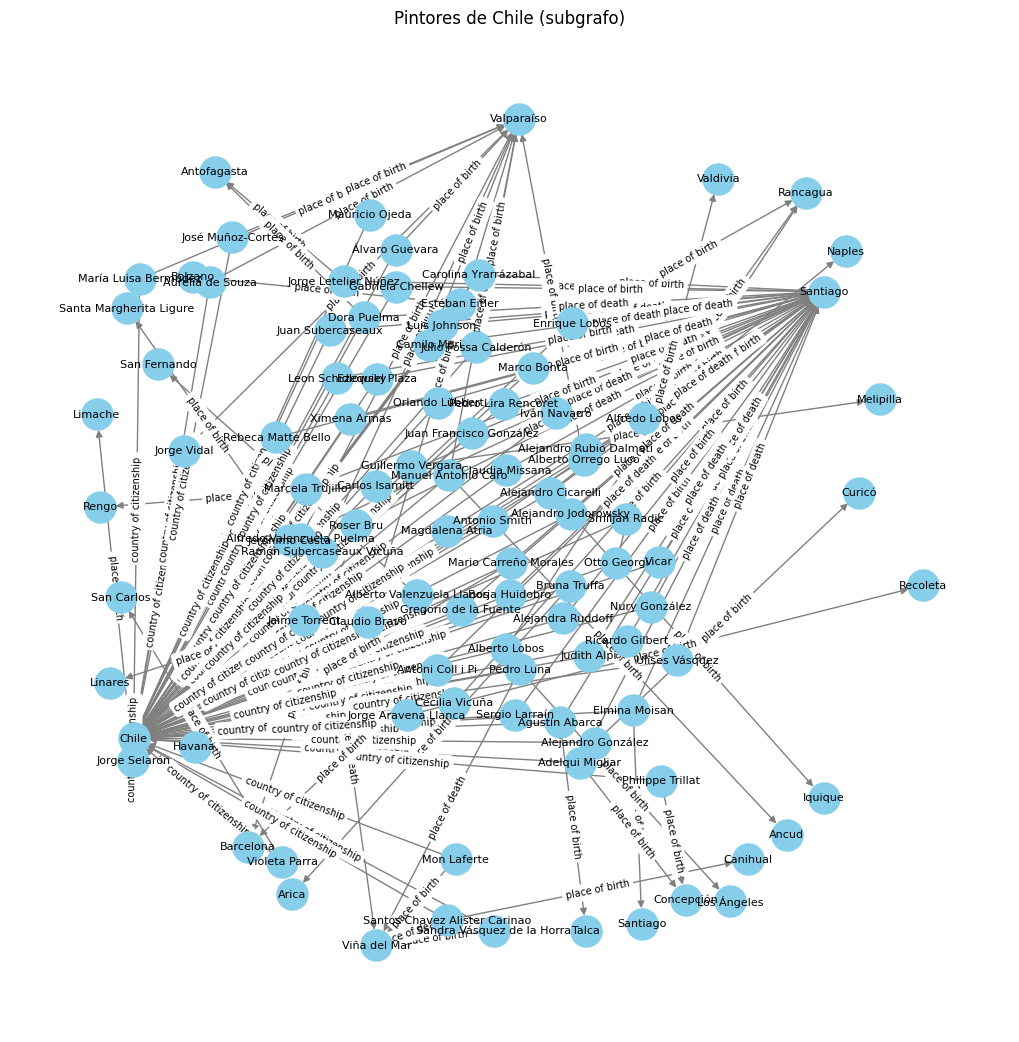

In [3]:
if __name__ == "__main__":
    # EJEMPLO A: Pintores de Chile
    # - Pa√≠s de ciudadan√≠a: Chile (Q298) -> propiedad P27
    # - Ocupaci√≥n: pintor (Q1028181) -> propiedad P106
    chile = ["Q298"]
    pintor = ["Q1028181"]
    items_chile_pintores = paginate_search(
        country_qids=chile,
        filters={"P27": chile, "P106": pintor},   # puedes sumar m√°s filtros si quieres
        max_entities=120
    )
    print(f"Encontradas {len(items_chile_pintores)} entidades (pintores de Chile).")
    triplets_chile = fetch_triplets_for_entities([qid for qid, _ in items_chile_pintores])
    graph_chile = build_graph_dict(
        triplets_chile,
        metadata={"title": "Pintores de Chile (subgrafo)", "filters": {"P27": chile, "P106": pintor}}
    )
    save_graph_json(graph_chile, "GC_pintores_chile.json")
    print("Guardado: GC_pintores_chile.json")
#
    ## Para graficar cuando quieras:
    plot_graph_from_json("GC_pintores_chile.json", max_nodes=100)


## Scrapping de pintores en LATAM

In [38]:
if __name__ == "__main__":
    # Pa√≠ses LATAM ‚Üí QIDs (Wikidata)
    LATAM_COUNTRIES_QIDS = {
        "Argentina": "Q414",
        "Bolivia": "Q750",
        "Brasil": "Q155",
        "Chile": "Q298",
        "Colombia": "Q739",
        "Costa Rica": "Q800",
        "Cuba": "Q241",
        "Ecuador": "Q736",
        "El Salvador": "Q792",
        "Guatemala": "Q774",
        "Honduras": "Q783",
        "M√©xico": "Q96",
        "Nicaragua": "Q811",
        "Panam√°": "Q804",
        "Paraguay": "Q733",
        "Per√∫": "Q419",
        "Rep√∫blica Dominicana": "Q786",
        "Uruguay": "Q77",
        "Venezuela": "Q717",
    }

    # Lista de QIDs para el filtro por ciudadan√≠a (P27)
    latam_country_qids = list(LATAM_COUNTRIES_QIDS.values())

    # QID de ocupaci√≥n: pintor
    pintor_qid = "Q1028181"  # occupation (P106) = painter

    # üîé B√∫squeda de ‚Äúpintores de LATAM‚Äù (usa las funciones que ya te dej√©)
    items_latam_pintores = paginate_search(
        country_qids=latam_country_qids,
        filters={
            "P27": latam_country_qids,     # pa√≠s de ciudadan√≠a ‚àà LATAM
            "P106": [pintor_qid],          # ocupaci√≥n = pintor
        },
        max_entities=10000
    )

    #  Tripletas + JSON
    triplets = fetch_triplets_for_entities([qid for qid, _ in items_latam_pintores])
    graph_latam = build_graph_dict(
        triplets,
        metadata={
            "title": "Pintores Latinoamericanos (subgrafo)",
            "filters": {"P27": latam_country_qids, "P106": [pintor_qid]}
        }
    )
    save_graph_json(graph_latam, "kg_pintores_latam.json")

    # Cuando quieras graficar (sin guardar .png):
    plot_graph_from_json("kg_pintores_latam.json", max_nodes=100)


RemoteDisconnected: Remote end closed connection without response

In [40]:
def plot_graph_from_json(
    path: str,
    max_nodes: int = 300,
    label_edges: bool = True,
    k_layout: float = 0.7,
    figsize: Tuple[int, int] = (10, 10)
):
    """
    Carga un .json del KG y lo grafica en una figura de matplotlib (no guarda PNG).
    """
    data = load_graph_json(path)
    G = nx.DiGraph()

    # limitar para plots grandes
    nodes = data["nodes"][:max_nodes]
    node_ids = set(n["id"] for n in nodes)
    id2label = {n["id"]: n["label"] for n in nodes}

    for n in nodes:
        G.add_node(n["id"], label=n["label"], ntype=n["type"])

    for e in data["edges"]:
        if e["source"] in node_ids and e["target"] in node_ids:
            G.add_edge(e["source"], e["target"], label=e["property_label"])

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=k_layout, seed=42)
    nx.draw(
        G, pos,
        with_labels=True,
        labels=id2label,
        node_size=100,
        node_color="skyblue",
        font_size=6,
        edge_color="gray",
        arrows=True
    )
    if label_edges:
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title(data.get("metadata", {}).get("title", "Grafo de Conocimiento"))
    plt.tight_layout()
    plt.show()

In [39]:
print(f"Encontradas {len(items_latam_pintores)} entidades (pintores de LATAM).")

Encontradas 5778 entidades (pintores de LATAM).


C:\Users\tomas\AppData\Local\Temp\ipykernel_25796\3576602809.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


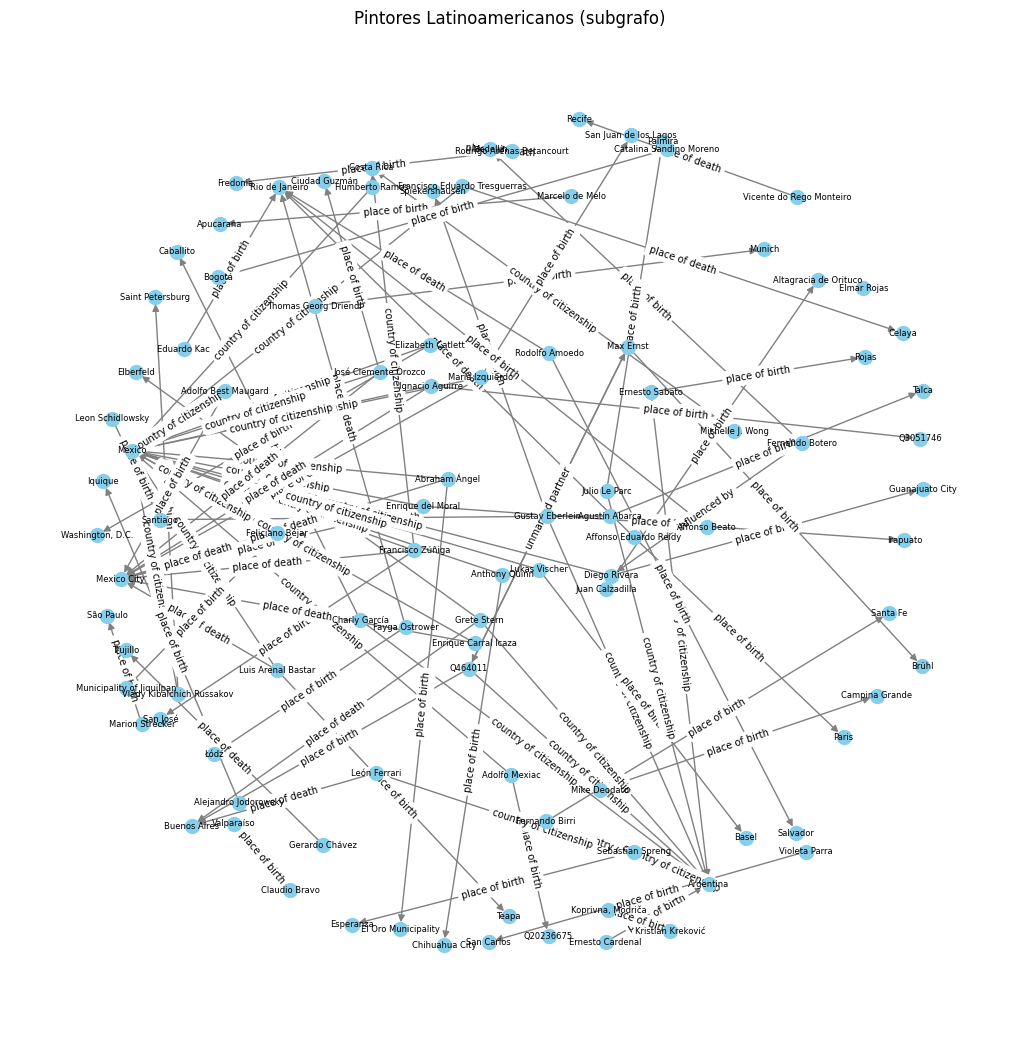

In [41]:
plot_graph_from_json("kg_pintores_latam.json", max_nodes=100)

## Scrapping de instrumentos musicales de LATAM (fail test)

In [ ]:
if __name__ == "__main__":

    LATAM_COUNTRIES_QIDS = [
        "Q414","Q750","Q155","Q298","Q739","Q800","Q241","Q736","Q792","Q774",
        "Q783","Q96","Q811","Q804","Q733","Q419","Q786","Q77","Q717"
    ]
    
    instrumento_qid = "Q34379"  # musical instrument
    
    items_instrumentos_latam = paginate_search(
        country_qids=LATAM_COUNTRIES_QIDS,
        filters={
            "P495": LATAM_COUNTRIES_QIDS,
            "P31": [instrumento_qid]
        },
        max_entities=500
    )
    
    triplets_instr = fetch_triplets_for_entities([qid for qid, _ in items_instrumentos_latam])
    graph_instr = build_graph_dict(
        triplets_instr,
        metadata={"title": "Instrumentos musicales latinoamericanos",
                  "filters": {"P495": LATAM_COUNTRIES_QIDS, "P31": [instrumento_qid]}}
    )
    save_graph_json(graph_instr, "kg_instrumentos_latam.json")
    

In [ ]:
print(f"Encontradas {len(items_latam_instrumentos)} entidades (instrumentos de LATAM).")

In [ ]:
plot_graph_from_json("GC_instrumentos_latam.json", max_nodes=100)

## Scrapping sitios de patrimonio mundial (fail test)

In [60]:
import os, json, time, random, socket
from urllib.error import HTTPError, URLError

CHECKPOINT_DIR = "ckpt_sitios"   # cambia el nombre para otros dominios si quieres
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def _jsonl_path_items(country_qid, type_qid):
    return os.path.join(CHECKPOINT_DIR, f"items_{country_qid}_{type_qid}.jsonl")

def _jsonl_path_triplets(country_qid, type_qid):
    return os.path.join(CHECKPOINT_DIR, f"triplets_{country_qid}_{type_qid}.jsonl")

def append_jsonl(path, records):
    """Append seguro a JSONL (lista de dicts o strings)."""
    with open(path, "a", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

def read_jsonl(path):
    """Lee JSONL si existe, si no devuelve []."""
    out = []
    if not os.path.exists(path):
        return out
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            out.append(json.loads(line))
    return out

def read_qids_from_items_jsonl(path):
    """Devuelve set de QIDs (strings) desde JSONL de items (cada l√≠nea es {'qid': 'Qxx'})."""
    qids = set()
    if not os.path.exists(path):
        return qids
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            qid = obj["qid"] if isinstance(obj, dict) else obj
            qids.add(qid)
    return qids

from SPARQLWrapper import SPARQLWrapper, JSON
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"

def _sparql(query: str, *, endpoint: str = WIKIDATA_ENDPOINT, throttle_s: float = 0.25,
            max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60) -> dict:
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(endpoint)
            s.setQuery(query)
            s.setReturnFormat(JSON)
            try:
                s.setTimeout(timeout_s * 1000)
            except Exception:
                s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0:
                time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep * (2 ** attempt) + random.uniform(0, 0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep)
                continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep * (2 ** attempt) + random.uniform(0, 0.5)
            print(f"[WARN] Error de red: {e}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep)
            continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")


PAGE_SIZE = 150
SLEEP_BETWEEN_PAGES = 0.25

def robust_items_by_country_and_type_checkpointed(
    country_qid: str,
    type_qid: str,
    prop_country: str = "P17",
    prop_type: str = "P31",
    page_size: int = PAGE_SIZE,
    max_per_combo: int = 4000
) -> set:
    """
    Descarga ?item en p√°ginas y guarda cada p√°gina en JSONL:
      ckpt_sitios/items_{country}_{type}.jsonl   con l√≠neas: {"qid":"Qxxxx"}
    Reanuda si el archivo ya tiene QIDs.
    Devuelve el set de QIDs acumulados para esa combinaci√≥n.
    """
    items_path = _jsonl_path_items(country_qid, type_qid)
    seen = read_qids_from_items_jsonl(items_path)  # reanudar
    print(f"   [ckpt] Ya hab√≠a {len(seen)} QIDs guardados para ({country_qid}, {type_qid})")

    offset = 0
    # Si ya tienes algunos, un truco: avanza offset aproximado en m√∫ltiplos de page_size
    # (no perfecto, pero evitamos rehacer demasiadas p√°ginas)
    approx_pages_done = len(seen) // page_size
    offset = approx_pages_done * page_size

    while len(seen) < max_per_combo:
        q = f"""
        SELECT DISTINCT ?item WHERE {{
          VALUES ?country {{ wd:{country_qid} }}
          ?item wdt:{prop_country} ?country .
          ?item wdt:{prop_type}/wdt:P279* wd:{type_qid} .
        }}
        LIMIT {page_size}
        OFFSET {offset}
        """
        data = _sparql(q)
        rows = data["results"]["bindings"]
        if not rows:
            break

        page_qids = []
        for b in rows:
            qid = b["item"]["value"].split("/")[-1]
            if qid not in seen:
                seen.add(qid)
                page_qids.append({"qid": qid})

        if page_qids:
            append_jsonl(items_path, page_qids)  # ‚Üê GUARDADO INCREMENTAL
            print(f"   [ckpt] Guardada p√°gina (offset={offset}), +{len(page_qids)} nuevos, total {len(seen)}")

        offset += page_size
        if SLEEP_BETWEEN_PAGES:
            time.sleep(SLEEP_BETWEEN_PAGES)

    return seen
def robust_multi_country_multi_type_checkpointed(
    country_qids: list,
    type_qids: list,
    prop_country: str = "P17",
    prop_type: str = "P31",
    per_combo_limit: int = 4000
) -> set:
    """
    Itera por pa√≠s y tipo, usando checkpoint por combinaci√≥n.
    Devuelve set global de QIDs √∫nicos.
    """
    all_qids = set()
    for cq in country_qids:
        for tq in type_qids:
            print(f"‚Üí Pa√≠s {cq} | Tipo {tq}")
            qids = robust_items_by_country_and_type_checkpointed(
                country_qid=cq,
                type_qid=tq,
                prop_country=prop_country,
                prop_type=prop_type,
                page_size=PAGE_SIZE,
                max_per_combo=per_combo_limit
            )
            print(f"   {len(qids)} items (acumulado global {len(all_qids) + len(qids - all_qids)})")
            all_qids |= qids
    print(f"Total global QIDs √∫nicos: {len(all_qids)}")
    return all_qids
def fetch_triplets_for_entities_batched_with_ckpt(
    item_qids: list,
    country_qid: str,
    type_qid: str,
    batch_size: int = 180
) -> None:
    """
    Descarga tripletas por lotes y guarda en:
      ckpt_sitios/triplets_{country}_{type}.jsonl
    Cada l√≠nea es una tripleta dict, compatible con tu build_graph_dict.
    Reanuda saltando QIDs ya procesados (mirando triplets guardadas).
    """
    trip_path = _jsonl_path_triplets(country_qid, type_qid)

    # Identificar QIDs ya procesados leyendo tripletas guardadas
    done = set()
    if os.path.exists(trip_path):
        for t in read_jsonl(trip_path):
            if isinstance(t, dict) and "subject_qid" in t:
                done.add(t["subject_qid"])

    pending = [q for q in item_qids if q not in done]
    print(f"   [trip] {len(done)} sujetos ya procesados, {len(pending)} pendientes.")

    for i in range(0, len(pending), batch_size):
        batch = pending[i:i+batch_size]
        try:
            trip = fetch_triplets_for_entities(batch)  # ‚Üê tu funci√≥n existente
            # Guardar inmediatamente
            append_jsonl(trip_path, trip)
            print(f"   [trip] Guardado lote {i//batch_size+1} ({len(trip)} tripletas) ‚Äî sujetos {len(done)+len(batch)}")
        except Exception as e:
            print(f"[ERROR] Lote {i//batch_size+1} fall√≥: {e}. Continuando con el siguiente‚Ä¶")
            # seguimos; el checkpoint ya evit√≥ perder lo previo
            continue



In [73]:
def consolidate_triplets_to_graph_json(output_path: str, title: str, domain_tag: str = "sitios_latam"):
    """
    Lee TODOS los triplets_*.jsonl del CHECKPOINT_DIR, construye nodos/edges
    y guarda un √∫nico grafo .json final.
    """
    # Cargar todas las tripletas
    all_triplets = []
    for fname in os.listdir(CHECKPOINT_DIR):
        if fname.startswith("triplets_") and fname.endswith(".jsonl"):
            all_triplets.extend(read_jsonl(os.path.join(CHECKPOINT_DIR, fname)))
    print(f"Consolidando {len(all_triplets)} tripletas‚Ä¶")

    graph = build_graph_dict(all_triplets, metadata={"title": title, "domain": domain_tag})
    save_graph_json(graph, output_path)
    print(f"‚úÖ Guardado: {output_path} (nodos {len(graph['nodes'])}, aristas {len(graph['edges'])})")

# Ejemplo:
# consolidate_triplets_to_graph_json("kg_sitios_interes_latam.json",
#                                    title="Sitios de inter√©s geogr√°fico en LATAM",
#                                    domain_tag="sitios_latam")


In [66]:
LATAM_COUNTRIES_QIDS = [
    #"Q414","Q750","Q155","Q298","Q739", "Q800", completados -> Q800 falla por mucha info de areas protegidas
    #"Q241","Q736","Q792", -> Q792 falla por mucha info de areas protegidas
    #"Q774","Q783","Q96", "Q811", #-> Q811 falla por mucha info de landmarks
    #"Q804","Q733", -> Q733 falla por mucha info de landmarks
    "Q419","Q786","Q77","Q717"
]


# Define tus tipos concretos de sitios
SITIOS_TIPOS = ["Q570116", "Q2221906", "Q839954"]  # atracci√≥n, landmark, √°rea protegida

# 1) Recolecci√≥n con checkpoint (QIDs √∫nicos globales por conveniencia)
qids_global = robust_multi_country_multi_type_checkpointed(
    country_qids=LATAM_COUNTRIES_QIDS,
    type_qids=SITIOS_TIPOS,
    prop_country="P17",
    prop_type="P31",
    per_combo_limit=2000
)

# 2) Tripletas por combinaci√≥n pa√≠s-tipo (usa los JSONL de items ya guardados)
for cq in LATAM_COUNTRIES_QIDS:
    for tq in SITIOS_TIPOS:
        items_path = _jsonl_path_items(cq, tq)
        qids = sorted(read_qids_from_items_jsonl(items_path))
        if not qids:
            continue
        print(f"‚Üí Tripletas ({cq}, {tq}) con {len(qids)} sujetos")
        fetch_triplets_for_entities_batched_with_ckpt(qids, country_qid=cq, type_qid=tq, batch_size=180)



    


‚Üí Pa√≠s Q804 | Tipo Q570116
   [ckpt] Ya hab√≠a 0 QIDs guardados para (Q804, Q570116)
   [ckpt] Guardada p√°gina (offset=0), +3 nuevos, total 3
   3 items (acumulado global 3)
‚Üí Pa√≠s Q804 | Tipo Q2221906
   [ckpt] Ya hab√≠a 0 QIDs guardados para (Q804, Q2221906)
   [ckpt] Guardada p√°gina (offset=0), +150 nuevos, total 150
   [ckpt] Guardada p√°gina (offset=150), +147 nuevos, total 297
[WARN] HTTP 504. Reintentando en 1.0s (intento 1/6)‚Ä¶
   [ckpt] Guardada p√°gina (offset=300), +53 nuevos, total 350
   [ckpt] Guardada p√°gina (offset=450), +113 nuevos, total 463
   [ckpt] Guardada p√°gina (offset=600), +117 nuevos, total 580
   [ckpt] Guardada p√°gina (offset=750), +56 nuevos, total 636
   [ckpt] Guardada p√°gina (offset=900), +150 nuevos, total 786
   [ckpt] Guardada p√°gina (offset=1050), +85 nuevos, total 871
   [ckpt] Guardada p√°gina (offset=1200), +150 nuevos, total 1021
[WARN] HTTP 504. Reintentando en 1.3s (intento 1/6)‚Ä¶
   [ckpt] Guardada p√°gina (offset=1350), +150 n

RuntimeError: SPARQL fall√≥ tras 6 reintentos: HTTP Error 504: Gateway Timeout

In [74]:
import os, glob, re, json

# üëâ tu carpeta en Windows (nota la r'' para evitar problemas de backslashes)
CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios"
assert os.path.isdir(CHECKPOINT_DIR), f"No existe: {CHECKPOINT_DIR}"


In [75]:
# Encuentra items_* con o sin .jsonl
item_files = glob.glob(os.path.join(CHECKPOINT_DIR, "items_*"))
if not item_files:
    item_files = glob.glob(os.path.join(CHECKPOINT_DIR, "items_*.jsonl"))

print(f"Encontrados {len(item_files)} archivos de items")

# Extrae (country_qid, type_qid) desde el nombre
pairs = []
for f in item_files:
    base = os.path.basename(f)
    m = re.match(r"items_(Q\d+)_(Q\d+)(?:\.jsonl)?$", base)
    if m:
        cq, tq = m.group(1), m.group(2)
        pairs.append((cq, tq, f))
    else:
        print("No pude parsear:", base)

print(f"{len(pairs)} combinaciones (pa√≠s,tipo) detectadas")
pairs[:5]


Encontrados 41 archivos de items
41 combinaciones (pa√≠s,tipo) detectadas


[('Q155',
  'Q2221906',
  'C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\\items_Q155_Q2221906.jsonl'),
 ('Q155',
  'Q570116',
  'C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\\items_Q155_Q570116.jsonl'),
 ('Q155',
  'Q839954',
  'C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\\items_Q155_Q839954.jsonl'),
 ('Q241',
  'Q2221906',
  'C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\\items_Q241_Q2221906.jsonl'),
 ('Q241',
  'Q570116',
  'C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\\items_Q241_Q570116.jsonl')]

In [76]:
def read_qids_generic(items_path: str):
    qids = set()
    with open(items_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Primero intentamos JSON
            try:
                obj = json.loads(line)
                if isinstance(obj, dict) and "qid" in obj:
                    qids.add(obj["qid"])
                    continue
                # Si fuera un string JSON "Q123"
                if isinstance(obj, str) and obj.startswith("Q"):
                    qids.add(obj)
                    continue
            except Exception:
                pass
            # Fallback: parsear ‚ÄúQ\d+‚Äù crudo
            m = re.search(r"(Q\d+)", line)
            if m:
                qids.add(m.group(1))
    return sorted(qids)


In [77]:
# Si no la tienes definida, vuelve a definirla r√°pido:
def load_graph_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def save_graph_json(graph_dict: dict, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(graph_dict, f, ensure_ascii=False, indent=2)

def build_graph_dict(triplets, metadata=None):
    nodes = {}
    edges = []
    def add_node(node_id, label, is_entity):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}
    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True)
            tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False)
            tgt = o
        edges.append({"source": s, "target": tgt, "property_pid": t["property_pid"], "property_label": t["property_label"]})
    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_path: str, title: str, domain_tag: str = "sitios_latam"):
    # Lee todos los triplets_*.jsonl en CHECKPOINT_DIR
    all_triplets = []
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f, "r", encoding="utf-8") as fh:
            for line in fh:
                try:
                    obj = json.loads(line)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_triplets.append(obj)
                except Exception:
                    pass
    print(f"Consolidando {len(all_triplets)} tripletas‚Ä¶")
    graph = build_graph_dict(all_triplets, metadata={"title": title, "domain": domain_tag})
    save_graph_json(graph, output_path)
    print(f"‚úÖ Guardado: {output_path} (nodos {len(graph['nodes'])}, aristas {len(graph['edges'])})")

# Llamada de consolidaci√≥n:
salida = os.path.join(CHECKPOINT_DIR, "kg_sitios_interes_latam.json")
consolidate_triplets_to_graph_json(salida, title="Sitios de inter√©s geogr√°fico en LATAM", domain_tag="sitios_latam")


Consolidando 0 tripletas‚Ä¶
‚úÖ Guardado: C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\kg_sitios_interes_latam.json (nodos 0, aristas 0)


In [50]:
print(f"Encontradas {len(items_sitios_latam)} entidades (instrumentos de LATAM).")

NameError: name 'items_sitios_latam' is not defined

In [69]:
consolidate_triplets_to_graph_json("kg_sitios_interes_latam.json",
                                    title="Sitios de inter√©s geogr√°fico en LATAM",
                                    domain_tag="sitios_latam")

Consolidando 0 tripletas‚Ä¶
‚úÖ Guardado: kg_sitios_interes_latam.json (nodos 0, aristas 0)


In [ ]:
plot_graph_from_json("GC_instrumentos_latam.json", max_nodes=100)

## Scrapping de landmarks LATAM

In [14]:
# -*- coding: utf-8 -*-
import os, re, json, time, random, socket, glob
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# ========= CONFIG =========
CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LATAM_COUNTRIES_QIDS = [
    #"Q414","Q750","Q155","Q298","Q739","Q800", <- completados, se demoraron 100 minn
    #"Q241", -> Q241 falla por mucha info de landmarks
    #"Q736","Q792","Q774", -> Q774 falla por mucha info
    "Q783","Q96","Q811","Q804","Q733","Q419","Q786","Q77","Q717"
]

# Ejemplos (elige 1 o varios). Para bajar carga, empieza con UNO:
#   "Q2221906" = landmark
#   "Q570116"  = tourist attraction
#   "Q839954"  = protected area
TYPE_QIDS = ["Q2221906"]   # <-- prueba con uno; luego agrega m√°s si quieres

PROP_COUNTRY = "P17"       # sitios -> pa√≠s donde est√° ubicado
PROP_TYPE    = "P31"       # instancia de
PAGE_SIZE    = 150         # p√°gina SPARQL
PER_COMBO_MAX = 4000       # m√°ximo por (pa√≠s,tipo)
TRIPLET_BATCH = 180        # batch para pedir tripletas
SLEEP_BETWEEN_PAGES = 0.25

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

# ========= UTILIDADES SPARQL ROBUSTO =========
def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try:
                s.setTimeout(timeout_s * 1000)
            except Exception:
                s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0:
                time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# ========= JSONL / OFFSET CHECKPOINT =========
def _items_path(cq, tq):     return os.path.join(CHECKPOINT_DIR, f"items_{cq}_{tq}.jsonl")
def _triplets_path(cq, tq):  return os.path.join(CHECKPOINT_DIR, f"triplets_{cq}_{tq}.jsonl")
def _offset_path(cq, tq):    return os.path.join(CHECKPOINT_DIR, f"offset_{cq}_{tq}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_jsonl(path):
    out=[]
    if not os.path.exists(path): return out
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line: continue
            out.append(json.loads(line))
    return out

def _read_done_subjects(trip_path):
    done=set()
    if not os.path.exists(trip_path): return done
    with open(trip_path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(cq,tq):
    p=_offset_path(cq,tq)
    if not os.path.exists(p): return 0
    try:
        return int(open(p,"r").read().strip())
    except:
        return 0

def _write_offset(cq,tq,offset):
    with open(_offset_path(cq,tq),"w") as f:
        f.write(str(offset))

# ========= TRIPLETAS (igual ‚Äúque antes‚Äù) =========
DEFAULT_PROP_WHITELIST = [
    "P31","P106","P136","P495","P27","P19","P20","P69","P166","P737","P739",
    "P135","P1303","P264","P451","P800","P279","P361","P131"
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or DEFAULT_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)

    # sin labels para items muy grandes ser√≠a m√°s liviano, pero aqu√≠ s√≠ los queremos (como antes)
    query = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(query)
    trip=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        p_iri  = b["p"]["value"]
        pid    = p_iri.split("/")[-1]
        pid    = pid.split(":")[-1] if ":" in pid else pid
        p_lab  = b.get("propLabel",{}).get("value", pid)
        o_val  = b["o"]["value"]
        o_lab  = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        trip.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return trip

# ========= P√ÅGINAS DE √çTEMS (SOLO IDs) =========
def fetch_items_page(country_qid: str, type_qid: str, offset: int, limit: int,
                     prop_country: str=PROP_COUNTRY, prop_type: str=PROP_TYPE) -> List[str]:
    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{country_qid} }}
      ?item wdt:{prop_country} ?country .
      ?item wdt:{prop_type}/wdt:P279* wd:{type_qid} .
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]

# ========= STREAMING POR (PA√çS, TIPO) CON CHECKPOINT REAL =========
def stream_country_type(cq: str, tq: str,
                        per_combo_max: int=PER_COMBO_MAX,
                        page_size: int=PAGE_SIZE,
                        triplet_batch: int=TRIPLET_BATCH):
    off = _read_offset(cq,tq)
    items_file = _items_path(cq,tq)
    trips_file = _triplets_path(cq,tq)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí ({cq},{tq}) reanudando desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page(cq, tq, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        # guarda la p√°gina de items (por trazabilidad) ‚Äî opcional
        _append_jsonl(items_file, [{"qid": q} for q in ids])
        # filtra los que faltan tripletas
        pend = [q for q in ids if q not in done]
        if pend:
            # por lotes de tripletas
            for i in range(0, len(pend), triplet_batch):
                chunk = pend[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk)
                    if trip:
                        _append_jsonl(trips_file, trip)      # ‚Üê GUARDA TRIPLETAS INMEDIATO
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch de tripletas en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)
        else:
            print(f"   [skip] p√°gina offset {off} ya cubierta por checkpoint")

        off += page_size
        _write_offset(cq,tq,off)            # ‚Üê ACTUALIZA OFFSET TRAS CADA P√ÅGINA
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_combo_max:
            print(f"   [cut] alcance per_combo_max={per_combo_max}"); break

    print(f"‚úî ({cq},{tq}) streaming listo. Tripletas nuevas en esta corrida: {total_new}")

# ========= CONSOLIDACI√ìN A KG (nodes/edges) =========
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}
    edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}

    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True)
            tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt, "property_pid": t["property_pid"], "property_label": t["property_label"]})

    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_path: str, title: str, domain_tag: str):
    # Lee TODOS los triplets_*.jsonl del CHECKPOINT_DIR
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    with open(output_path,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {output_path} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")


In [9]:
for cq in LATAM_COUNTRIES_QIDS:
    for tq in TYPE_QIDS:  # ["Q2221906"] ahora
        stream_country_type(cq, tq, per_combo_max=PER_COMBO_MAX, page_size=PAGE_SIZE, triplet_batch=TRIPLET_BATCH)


‚Üí (Q414,Q2221906) reanudando desde offset 0, sujetos ya con tripletas: 0
   [trip] +401 tripletas (sujetos 150), offset 0
   [trip] +277 tripletas (sujetos 300), offset 150
   [trip] +282 tripletas (sujetos 415), offset 300
   [trip] +326 tripletas (sujetos 565), offset 450
   [trip] +341 tripletas (sujetos 715), offset 600
   [trip] +342 tripletas (sujetos 864), offset 750
   [trip] +352 tripletas (sujetos 1014), offset 900
   [trip] +295 tripletas (sujetos 1138), offset 1050
   [trip] +117 tripletas (sujetos 1188), offset 1200
   [trip] +292 tripletas (sujetos 1296), offset 1350
   [trip] +379 tripletas (sujetos 1436), offset 1500
   [trip] +100 tripletas (sujetos 1486), offset 1650
   [trip] +153 tripletas (sujetos 1545), offset 1800
   [trip] +408 tripletas (sujetos 1695), offset 1950
   [trip] +302 tripletas (sujetos 1804), offset 2100
   [trip] +147 tripletas (sujetos 1853), offset 2250
   [trip] +150 tripletas (sujetos 1912), offset 2400
   [trip] +320 tripletas (sujetos 2038)

JSONDecodeError: Extra data: line 758 column 2 (char 17729)

In [11]:
for cq in LATAM_COUNTRIES_QIDS:
    for tq in TYPE_QIDS:  # ["Q2221906"] ahora
        stream_country_type(cq, tq, per_combo_max=PER_COMBO_MAX, page_size=PAGE_SIZE, triplet_batch=TRIPLET_BATCH)

‚Üí (Q241,Q2221906) reanudando desde offset 4050, sujetos ya con tripletas: 3215
[WARN] HTTP 504. Reintentando en 1.3s (intento 1/6)‚Ä¶
[WARN] HTTP 429. Reintentando en 1.8s (intento 2/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 3.5s (intento 3/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 6.7s (intento 4/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 13.2s (intento 5/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 25.6s (intento 6/6)‚Ä¶


RuntimeError: SPARQL fall√≥ tras 6 reintentos: HTTP Error 504: Gateway Timeout

In [13]:
for cq in LATAM_COUNTRIES_QIDS:
    for tq in TYPE_QIDS:  # ["Q2221906"] ahora
        stream_country_type(cq, tq, per_combo_max=PER_COMBO_MAX, page_size=PAGE_SIZE, triplet_batch=TRIPLET_BATCH)

‚Üí (Q736,Q2221906) reanudando desde offset 3450, sujetos ya con tripletas: 2925
   [fin] no hay m√°s p√°ginas.
‚úî (Q736,Q2221906) streaming listo. Tripletas nuevas en esta corrida: 0
‚Üí (Q792,Q2221906) reanudando desde offset 1800, sujetos ya con tripletas: 1532
   [fin] no hay m√°s p√°ginas.
‚úî (Q792,Q2221906) streaming listo. Tripletas nuevas en esta corrida: 0
‚Üí (Q774,Q2221906) reanudando desde offset 1200, sujetos ya con tripletas: 1179
   [trip] +333 tripletas (sujetos 1329), offset 1200
   [trip] +113 tripletas (sujetos 1384), offset 1350
   [trip] +205 tripletas (sujetos 1525), offset 1500
[WARN] HTTP 504. Reintentando en 1.0s (intento 1/6)‚Ä¶
[WARN] HTTP 429. Reintentando en 1.9s (intento 2/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 3.2s (intento 3/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 6.7s (intento 4/6)‚Ä¶
[WARN] HTTP 504. Reintentando en 13.0s (intento 5/6)‚Ä¶
[WARN] HTTP 429. Reintentando en 25.6s (intento 6/6)‚Ä¶


RuntimeError: SPARQL fall√≥ tras 6 reintentos: HTTP Error 429: Too Many Requests

In [15]:
for cq in LATAM_COUNTRIES_QIDS:
    for tq in TYPE_QIDS:  # ["Q2221906"] ahora
        stream_country_type(cq, tq, per_combo_max=PER_COMBO_MAX, page_size=PAGE_SIZE, triplet_batch=TRIPLET_BATCH)

‚Üí (Q783,Q2221906) reanudando desde offset 0, sujetos ya con tripletas: 0
   [trip] +317 tripletas (sujetos 150), offset 0
   [trip] +305 tripletas (sujetos 300), offset 150
   [trip] +296 tripletas (sujetos 446), offset 300
   [trip] +300 tripletas (sujetos 596), offset 450
   [trip] +194 tripletas (sujetos 693), offset 600
   [trip] +300 tripletas (sujetos 843), offset 750
   [trip] +168 tripletas (sujetos 927), offset 900
   [trip] +265 tripletas (sujetos 1060), offset 1050
   [trip] +143 tripletas (sujetos 1132), offset 1200
   [trip] +294 tripletas (sujetos 1279), offset 1350
   [trip] +196 tripletas (sujetos 1377), offset 1500
   [trip] +302 tripletas (sujetos 1527), offset 1650
   [trip] +230 tripletas (sujetos 1642), offset 1800
   [trip] +158 tripletas (sujetos 1721), offset 1950
   [trip] +178 tripletas (sujetos 1810), offset 2100
[WARN] HTTP 504. Reintentando en 0.8s (intento 1/6)‚Ä¶
   [trip] +178 tripletas (sujetos 1899), offset 2250
   [trip] +299 tripletas (sujetos 2049

In [16]:
salida = os.path.join(CHECKPOINT_DIR, "kg_sitios_interes_latam.json")
consolidate_triplets_to_graph_json(salida, title="Sitios de inter√©s geogr√°fico en LATAM", domain_tag="sitios_latam")


Consolidando 103493 tripletas‚Ä¶
‚úÖ Guardado: C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios\kg_sitios_interes_latam.json (nodos 54227, aristas 103493)


In [ ]:
plot_graph_from_json("GC_peliculas_latam.json", max_nodes=100)

## Scrapping peliculas LATAM

In [23]:
# -*- coding: utf-8 -*-
import os, re, json, time, random, socket, glob
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# --- CONFIG PEL√çCULAS ---
import os

# Carpeta separada para checkpoints de pel√≠culas
CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_peliculas"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Pa√≠ses LATAM (mismos de antes)
LATAM_COUNTRIES_QIDS = [
    "Q414","Q750","Q155","Q298","Q739","Q800","Q241","Q736","Q792","Q774",
    "Q783","Q96","Q811","Q804","Q733","Q419","Q786","Q77","Q717"
]

# Tipo: Pel√≠cula
TYPE_QIDS = ["Q11424"]     # film (incluiremos subclases con /wdt:P279*)

# Para pel√≠culas el pa√≠s es "pa√≠s de origen"
PROP_COUNTRY = "P495"
# Tipo/instancia: se mantiene P31
PROP_TYPE    = "P31"

# Par√°metros de robustez (aj√∫stalos si hace falta)
PAGE_SIZE       = 150
PER_COMBO_MAX   = 4000
TRIPLET_BATCH   = 180
SLEEP_BETWEEN_PAGES = 0.25

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

# ========= UTILIDADES SPARQL ROBUSTO =========
def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try:
                s.setTimeout(timeout_s * 1000)
            except Exception:
                s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0:
                time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# ========= JSONL / OFFSET CHECKPOINT =========
def _items_path(cq, tq):     return os.path.join(CHECKPOINT_DIR, f"items_{cq}_{tq}.jsonl")
def _triplets_path(cq, tq):  return os.path.join(CHECKPOINT_DIR, f"triplets_{cq}_{tq}.jsonl")
def _offset_path(cq, tq):    return os.path.join(CHECKPOINT_DIR, f"offset_{cq}_{tq}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_jsonl(path):
    out=[]
    if not os.path.exists(path): return out
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line: continue
            out.append(json.loads(line))
    return out

def _read_done_subjects(trip_path):
    done=set()
    if not os.path.exists(trip_path): return done
    with open(trip_path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(cq,tq):
    p=_offset_path(cq,tq)
    if not os.path.exists(p): return 0
    try:
        return int(open(p,"r").read().strip())
    except:
        return 0

def _write_offset(cq,tq,offset):
    with open(_offset_path(cq,tq),"w") as f:
        f.write(str(offset))

# ========= TRIPLETAS (igual ‚Äúque antes‚Äù) =========
# Reemplaza (o extiende) tu whitelist para pel√≠culas:
DEFAULT_PROP_WHITELIST = [
    "P31",    # instancia de
    "P136",   # g√©nero
    "P495",   # pa√≠s de origen
    "P364",   # idioma original de la obra
    "P577",   # fecha de publicaci√≥n/estreno
    "P57",    # director
    "P58",    # guionista
    "P161",   # reparto (cast member)
    "P162",   # productor
    "P272",   # productora
    "P344",   # director de fotograf√≠a
    "P915",   # locaci√≥n de rodaje
    "P449",   # red original (para TV; por si cae alguna)
    "P2047",  # (ignorar si no aplica; puedes quitarla)
    # gen√©ricas que ya usabas, por si suman se√±al:
    "P279","P361","P737","P739","P800"
]


def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or DEFAULT_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)

    # sin labels para items muy grandes ser√≠a m√°s liviano, pero aqu√≠ s√≠ los queremos (como antes)
    query = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(query)
    trip=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        p_iri  = b["p"]["value"]
        pid    = p_iri.split("/")[-1]
        pid    = pid.split(":")[-1] if ":" in pid else pid
        p_lab  = b.get("propLabel",{}).get("value", pid)
        o_val  = b["o"]["value"]
        o_lab  = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        trip.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return trip

# ========= P√ÅGINAS DE √çTEMS (SOLO IDs) =========
def fetch_items_page(country_qid: str, type_qid: str, offset: int, limit: int,
                     prop_country: str=PROP_COUNTRY, prop_type: str=PROP_TYPE) -> List[str]:
    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{country_qid} }}
      ?item wdt:{prop_country} ?country .
      ?item wdt:{prop_type}/wdt:P279* wd:{type_qid} .
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]

# ========= STREAMING POR (PA√çS, TIPO) CON CHECKPOINT REAL =========
def stream_country_type(cq: str, tq: str,
                        per_combo_max: int=PER_COMBO_MAX,
                        page_size: int=PAGE_SIZE,
                        triplet_batch: int=TRIPLET_BATCH):
    off = _read_offset(cq,tq)
    items_file = _items_path(cq,tq)
    trips_file = _triplets_path(cq,tq)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí ({cq},{tq}) reanudando desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page(cq, tq, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        # guarda la p√°gina de items (por trazabilidad) ‚Äî opcional
        _append_jsonl(items_file, [{"qid": q} for q in ids])
        # filtra los que faltan tripletas
        pend = [q for q in ids if q not in done]
        if pend:
            # por lotes de tripletas
            for i in range(0, len(pend), triplet_batch):
                chunk = pend[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk)
                    if trip:
                        _append_jsonl(trips_file, trip)      # ‚Üê GUARDA TRIPLETAS INMEDIATO
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch de tripletas en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)
        else:
            print(f"   [skip] p√°gina offset {off} ya cubierta por checkpoint")

        off += page_size
        _write_offset(cq,tq,off)            # ‚Üê ACTUALIZA OFFSET TRAS CADA P√ÅGINA
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_combo_max:
            print(f"   [cut] alcance per_combo_max={per_combo_max}"); break

    print(f"‚úî ({cq},{tq}) streaming listo. Tripletas nuevas en esta corrida: {total_new}")

# ========= CONSOLIDACI√ìN A KG (nodes/edges) =========
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}
    edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}

    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True)
            tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt, "property_pid": t["property_pid"], "property_label": t["property_label"]})

    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_path: str, title: str, domain_tag: str):
    # Lee TODOS los triplets_*.jsonl del CHECKPOINT_DIR
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    with open(output_path,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {output_path} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")


In [24]:
for cq in LATAM_COUNTRIES_QIDS:
    for tq in TYPE_QIDS:  # ["Q11424"]
        stream_country_type(
            cq, tq,
            per_combo_max=PER_COMBO_MAX,
            page_size=PAGE_SIZE,
            triplet_batch=TRIPLET_BATCH
        )


‚Üí (Q414,Q11424) reanudando desde offset 0, sujetos ya con tripletas: 0
   [trip] +3446 tripletas (sujetos 150), offset 0
   [trip] +3225 tripletas (sujetos 299), offset 150
   [trip] +2854 tripletas (sujetos 437), offset 300
   [trip] +2326 tripletas (sujetos 547), offset 450
   [trip] +2543 tripletas (sujetos 677), offset 600
   [trip] +1988 tripletas (sujetos 782), offset 750
   [trip] +2842 tripletas (sujetos 930), offset 900
   [trip] +1824 tripletas (sujetos 1028), offset 1050
   [trip] +2800 tripletas (sujetos 1178), offset 1200
   [trip] +909 tripletas (sujetos 1229), offset 1350
   [trip] +2963 tripletas (sujetos 1379), offset 1500
   [trip] +2813 tripletas (sujetos 1519), offset 1650
   [trip] +2574 tripletas (sujetos 1648), offset 1800
   [trip] +2139 tripletas (sujetos 1757), offset 1950
   [trip] +2637 tripletas (sujetos 1905), offset 2100
   [trip] +2475 tripletas (sujetos 2040), offset 2250
   [trip] +2519 tripletas (sujetos 2189), offset 2400
   [trip] +2342 tripletas 

In [25]:
salida = os.path.join(CHECKPOINT_DIR, "kg_peliculas_latam.json")
consolidate_triplets_to_graph_json(salida, title="Pel√≠culas en LATAM", domain_tag="peliculas_latam")

Consolidando 151363 tripletas‚Ä¶
‚úÖ Guardado: C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_peliculas\kg_peliculas_latam.json (nodos 34580, aristas 151363)


## Scrapping de danzas y bailes

In [23]:
# === CONFIG para la V√çA B (criterios por g√©nero/forma + dance music) ===
import os, json, time, random, socket, glob, re
from urllib.error import HTTPError, URLError
from typing import List, Dict
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# Carpeta de checkpoints para danzas por criterios (separada de las otras)
CHECKPOINT_DIR = r"C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_danzas_criterios"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- CONFIG DANZAS por PA√çS ---
import os, json, time, random, socket, glob, re
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

CHECKPOINT_DIR = r"C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_danzas_por_pais"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LATAM_COUNTRIES_QIDS = [
    "Q414","Q750","Q155","Q298","Q739","Q800","Q241","Q736","Q792","Q774",
    "Q783","Q96","Q811","Q804","Q733","Q419","Q786","Q77","Q717"
]

# Criterios ‚Äúbailables‚Äù:
INSTANCE_TYPES_QIDS = ["Q188451", "Q3046146"]   # music genre, musical form
SUBCLASS_ROOTS_QIDS = ["Q180018", "Q18345375", "Q18345375"]               # dance music

# Pa√≠s para danzas: pa√≠s de ORIGEN
PROP_COUNTRY = "P495"
PAGE_SIZE = 150
PER_COUNTRY_MAX = 4000
TRIPLET_BATCH = 180
SLEEP_BETWEEN_PAGES = 0.25


WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# Helpers de checkpoint
def _items_path():    return os.path.join(CHECKPOINT_DIR, f"items_criterios.jsonl")
def _triplets_path(): return os.path.join(CHECKPOINT_DIR, f"triplets_criterios.jsonl")
def _offset_path():   return os.path.join(CHECKPOINT_DIR, f"offset_criterios.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(trip_path):
    done=set()
    if not os.path.exists(trip_path): return done
    with open(trip_path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset():
    p=_offset_path()
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(offset: int):
    with open(_offset_path(),"w") as f: f.write(str(offset))

# Tripletas ‚Äúcomo antes‚Äù (puedes ajustar whitelist si quieres m√°s/menos aristas)
DANCE_PROP_WHITELIST = [
    "P31","P279","P361","P495","P17","P136","P131"
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or DANCE_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)

    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    T=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid    = b["p"]["value"].split("/")[-1]
        pid    = pid.split(":")[-1] if ":" in pid else pid
        p_lab  = b.get("propLabel",{}).get("value", pid)
        o_val  = b["o"]["value"]
        o_lab  = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        T.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return T


In [26]:
def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

def _items_path(cq):    return os.path.join(CHECKPOINT_DIR, f"items_{cq}.jsonl")
def _triplets_path(cq): return os.path.join(CHECKPOINT_DIR, f"triplets_{cq}.jsonl")
def _offset_path(cq):   return os.path.join(CHECKPOINT_DIR, f"offset_{cq}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(cq):
    p=_offset_path(cq)
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(cq,off):
    with open(_offset_path(cq),"w") as f: f.write(str(off))

# Propiedades √∫tiles para danzas/bailes
DANCE_PROP_WHITELIST = [
    "P31","P279","P361","P495","P17","P136","P131"
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or DANCE_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)
    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    out=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid = b["p"]["value"].split("/")[-1]
        pid = pid.split(":")[-1] if ":" in pid else pid
        p_lab = b.get("propLabel",{}).get("value", pid)
        o_val = b["o"]["value"]
        o_lab = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        out.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return out

def fetch_items_page_by_country(cq: str, offset: int, limit: int) -> List[str]:
    """
    √çtems que cumplen:
      - instancia de (music genre | musical form) (con subclases)
      - subclase de dance music (con jerarqu√≠a)
      - pa√≠s de origen = cq  (P495)
    """
    inst_vals = " ".join(f"wd:{q}" for q in INSTANCE_TYPES_QIDS)
    root_vals = " ".join(f"wd:{q}" for q in SUBCLASS_ROOTS_QIDS)
    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?itype {{ {inst_vals} }}
      VALUES ?root  {{ {root_vals} }}
      VALUES ?country {{ wd:{cq} }}

      ?item wdt:P31/wdt:P279* ?itype .
      ?item wdt:P279* ?root .
      ?item wdt:{PROP_COUNTRY} ?country .
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]

def stream_country(cq: str,
                   per_country_max: int=PER_COUNTRY_MAX,
                   page_size: int=PAGE_SIZE,
                   triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path(cq)
    trips_file = _triplets_path(cq)
    off = _read_offset(cq)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí Danzas por pa√≠s {cq} desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page_by_country(cq, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        _append_jsonl(items_file, [{"qid": q} for q in ids])  # trazabilidad

        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk, prop_whitelist=DANCE_PROP_WHITELIST)
                    if trip:
                        _append_jsonl(trips_file, trip)    # ‚Üê checkpoint inmediato
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(cq, off)                      # ‚Üê guardo offset
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_country_max:
            print(f"   [cut] per_country_max={per_country_max}"); break

    print(f"‚úî Pa√≠s {cq} listo. Tripletas nuevas: {total_new}")


In [27]:
for cq in LATAM_COUNTRIES_QIDS:
    stream_country(cq)


‚Üí Danzas por pa√≠s Q414 desde offset 0, sujetos ya con tripletas: 0
   [trip] +130 tripletas (sujetos 25), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q414 listo. Tripletas nuevas: 130
‚Üí Danzas por pa√≠s Q750 desde offset 0, sujetos ya con tripletas: 0
   [trip] +81 tripletas (sujetos 12), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q750 listo. Tripletas nuevas: 81
‚Üí Danzas por pa√≠s Q155 desde offset 0, sujetos ya con tripletas: 0
   [trip] +393 tripletas (sujetos 100), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q155 listo. Tripletas nuevas: 393
‚Üí Danzas por pa√≠s Q298 desde offset 0, sujetos ya con tripletas: 0
   [trip] +89 tripletas (sujetos 19), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q298 listo. Tripletas nuevas: 89
‚Üí Danzas por pa√≠s Q739 desde offset 0, sujetos ya con tripletas: 0
   [trip] +91 tripletas (sujetos 19), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q739 listo. Tripletas nuevas: 91
‚Üí Danzas por pa√≠s Q800 desde offset 0

In [28]:
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}; edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}
    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True); tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt,
                      "property_pid": t["property_pid"], "property_label": t["property_label"]})
    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_filename: str, title: str, domain_tag: str):
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    out = os.path.join(CHECKPOINT_DIR, output_filename)
    with open(out,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {out} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")

# Ejecuta consolidaci√≥n
consolidate_triplets_to_graph_json("kg_danzas_por_pais.json",
                                   title="Danzas y bailes por pa√≠s de origen (LATAM)",
                                   domain_tag="danzas_por_pais")


Consolidando 1401 tripletas‚Ä¶
‚úÖ Guardado: C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_danzas_por_pais\kg_danzas_por_pais.json (nodos 451, aristas 1401)


## Scrapping de grupos ind√≠genas de LATAM

In [30]:
# --- CONFIG IND√çGENAS POR PA√çS ---
import os, json, time, random, socket, glob, re
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_indigenas"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LATAM_COUNTRIES_QIDS = [
    "Q414","Q750","Q155","Q298","Q739","Q800","Q241","Q736","Q792","Q774",
    "Q783","Q96","Q811","Q804","Q733","Q419","Q786","Q77","Q717"
]

# Ra√≠ces de tipo:
ETHNIC_GROUP_QID = "Q41710"       # ethnic group (universal y muy usado)
INDIGENOUS_ROOTS_QIDS = []        # <- opcional: pon aqu√≠ QIDs de "indigenous people" si quieres exigirlo (p.ej. ["QXXXX"])

# Propiedades-pa√≠s que usamos para vincular el grupo a un pa√≠s
PROP_COUNTRY_DIRECT   = "P17"     # country (a veces usado en grupos)
PROP_INDEG_TO         = "P2341"   # indigenous to / native to
# V√≠a territorial: P131 (entidad territorial) y desde ah√≠ llegamos al pa√≠s por P17
PROP_ADMIN_ENTITY     = "P131"

# Robustez
PAGE_SIZE           = 150
PER_COUNTRY_MAX     = 4000
TRIPLET_BATCH       = 180
SLEEP_BETWEEN_PAGES = 0.25

# SPARQL
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# Paths de checkpoint
def _items_path(cq):    return os.path.join(CHECKPOINT_DIR, f"items_{cq}.jsonl")
def _triplets_path(cq): return os.path.join(CHECKPOINT_DIR, f"triplets_{cq}.jsonl")
def _offset_path(cq):   return os.path.join(CHECKPOINT_DIR, f"offset_{cq}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(cq):
    p=_offset_path(cq)
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(cq,off):
    with open(_offset_path(cq),"w") as f: f.write(str(off))
# Propiedades a extraer para el grafo
INDIGENOUS_PROP_WHITELIST = [
    "P31",    # instancia de
    "P279",   # subclase de
    "P361",   # parte de
    "P17",    # pa√≠s (si lo tienen)
    "P2341",  # indigenous to / native to
    "P131",   # entidad territorial administrativa
    "P495",   # pa√≠s de origen (a veces aparece)
    "P1705",  # nombre nativo
    "P37",    # idioma oficial/usado (a veces en items de grupo)
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or INDIGENOUS_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)
    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    out=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid = b["p"]["value"].split("/")[-1]
        pid = pid.split(":")[-1] if ":" in pid else pid
        p_lab = b.get("propLabel",{}).get("value", pid)
        o_val = b["o"]["value"]
        o_lab = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        out.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return out

def fetch_items_page_by_country(cq: str, offset: int, limit: int) -> List[str]:
    """
    Trae √≠tems que sean:
       (A) ethnic group  Y  vinculados a ?country por (P2341 | P17 | P131‚ÜíP17)
    o  (B) (opcional) instance/subclass of some INDIGENOUS_ROOTS_QIDS  Y  mismo v√≠nculo a ?country.
    """
    indigenous_block = ""
    if INDIGENOUS_ROOTS_QIDS:
        roots = " ".join(f"wd:{q}" for q in INDIGENOUS_ROOTS_QIDS)
        indigenous_block = f"""
        UNION {{
          VALUES ?iroot {{ {roots} }}
          ?item wdt:P31/wdt:P279* ?iroot .
          ?item (wdt:{PROP_INDEG_TO}|wdt:{PROP_COUNTRY_DIRECT}|wdt:{PROP_ADMIN_ENTITY}/wdt:{PROP_COUNTRY_DIRECT}) ?country .
        }}
        """

    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{cq} }}

      {{
        ?item wdt:P31/wdt:P279* wd:{ETHNIC_GROUP_QID} .
        ?item (wdt:{PROP_INDEG_TO}|wdt:{PROP_COUNTRY_DIRECT}|wdt:{PROP_ADMIN_ENTITY}/wdt:{PROP_COUNTRY_DIRECT}) ?country .
      }}
      {indigenous_block}
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]
def stream_country(cq: str,
                   per_country_max: int=PER_COUNTRY_MAX,
                   page_size: int=PAGE_SIZE,
                   triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path(cq)
    trips_file = _triplets_path(cq)
    off = _read_offset(cq)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí Pueblos ind√≠genas en {cq} desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page_by_country(cq, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        _append_jsonl(items_file, [{"qid": q} for q in ids])  # trazabilidad

        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk, prop_whitelist=INDIGENOUS_PROP_WHITELIST)
                    if trip:
                        _append_jsonl(trips_file, trip)    # ‚Üê checkpoint inmediato
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(cq, off)                      # ‚Üê guardo offset
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_country_max:
            print(f"   [cut] per_country_max={per_country_max}"); break

    print(f"‚úî Pa√≠s {cq} listo. Tripletas nuevas: {total_new}")


In [31]:
for cq in LATAM_COUNTRIES_QIDS:
    stream_country(cq)

‚Üí Pueblos ind√≠genas en Q414 desde offset 0, sujetos ya con tripletas: 0
   [trip] +317 tripletas (sujetos 57), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q414 listo. Tripletas nuevas: 317
‚Üí Pueblos ind√≠genas en Q750 desde offset 0, sujetos ya con tripletas: 0
   [trip] +176 tripletas (sujetos 47), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q750 listo. Tripletas nuevas: 176
‚Üí Pueblos ind√≠genas en Q155 desde offset 0, sujetos ya con tripletas: 0
   [trip] +501 tripletas (sujetos 150), offset 0
   [trip] +702 tripletas (sujetos 297), offset 150
   [trip] +300 tripletas (sujetos 372), offset 300
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q155 listo. Tripletas nuevas: 1503
‚Üí Pueblos ind√≠genas en Q298 desde offset 0, sujetos ya con tripletas: 0
   [trip] +166 tripletas (sujetos 42), offset 0
   [fin] no hay m√°s p√°ginas.
‚úî Pa√≠s Q298 listo. Tripletas nuevas: 166
‚Üí Pueblos ind√≠genas en Q739 desde offset 0, sujetos ya con tripletas: 0
   [trip] +380 tripletas (suj

In [32]:
# Consolidar a un KG √∫nico
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}; edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}
    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True); tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt,
                      "property_pid": t["property_pid"], "property_label": t["property_label"]})
    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_filename: str, title: str, domain_tag: str):
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    out = os.path.join(CHECKPOINT_DIR, output_filename)
    with open(out,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {out} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")

consolidate_triplets_to_graph_json("kg_pueblos_indigenas_latam.json",
                                   title="Pueblos ind√≠genas por pa√≠s (Latinoam√©rica)",
                                   domain_tag="indigenas_latam")

Consolidando 4079 tripletas‚Ä¶
‚úÖ Guardado: C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_indigenas\kg_pueblos_indigenas_latam.json (nodos 1453, aristas 4079)


## Scrappeo EEUU

### Pintores

In [34]:
# --- CONFIG PINTORXS USA ---
import os, json, time, random, socket, glob, re
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# Carpeta de checkpoints para este dominio
CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_pintores_us"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Pa√≠s objetivo: Estados Unidos
COUNTRY_QID = "Q30"          # United States of America

# Ra√≠z de ocupaci√≥n: painter
OCCUPATION_ROOT_QID = "Q1028181"  # painter

# Robustez
PAGE_SIZE           = 150     # √≠tems por p√°gina
PER_COUNTRY_MAX     = 12000   # tope de √≠tems a traer (aj√∫stalo si quieres)
TRIPLET_BATCH       = 180     # sujetos por lote al pedir tripletas
SLEEP_BETWEEN_PAGES = 0.25    # cortes√≠a para el endpoint

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"
def _sparql(query: str, throttle_s: float = 0.25, max_retries: int = 6, base_sleep: float = 0.8, timeout_s: int = 60):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (academic)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
                print(f"[WARN] HTTP {e.code}. Reintentando en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0,0.5)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s (intento {attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

def _items_path():    return os.path.join(CHECKPOINT_DIR, f"items_{COUNTRY_QID}.jsonl")
def _triplets_path(): return os.path.join(CHECKPOINT_DIR, f"triplets_{COUNTRY_QID}.jsonl")
def _offset_path():   return os.path.join(CHECKPOINT_DIR, f"offset_{COUNTRY_QID}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset():
    p=_offset_path()
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(off: int):
    with open(_offset_path(),"w") as f: f.write(str(off))
# Propiedades √∫tiles para humanos/artistas
PERSON_PROP_WHITELIST = [
    "P31",   # instancia de
    "P106",  # ocupaci√≥n
    "P27",   # pa√≠s de ciudadan√≠a
    "P19",   # lugar de nacimiento
    "P20",   # lugar de fallecimiento
    "P69",   # educado en
    "P166",  # premio
    "P737",  # influenciado por
    "P135",  # movimiento
    "P800",  # obra destacada
    "P131",  # ubicado en entidad territorial
    "P136",  # g√©nero/estilo
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or PERSON_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p if p.startswith('P') else p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)

    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    out=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid = b["p"]["value"].split("/")[-1]
        pid = pid.split(":")[-1] if ":" in pid else pid
        p_lab = b.get("propLabel",{}).get("value", pid)
        o_val = b["o"]["value"]
        o_lab = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        out.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return out

def fetch_items_page(offset: int, limit: int) -> List[str]:
    """
    Humanxs (Q5) con ciudadan√≠a USA (P27 = Q30) y ocupaci√≥n 'painter' (incluye sub-ocupaciones).
    """
    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{COUNTRY_QID} }}
      ?item wdt:P31 wd:Q5 .                          # humano
      ?item wdt:P27 ?country .                       # ciudadan√≠a USA
      ?item wdt:P106 ?occ .                          # ocupaci√≥n
      ?occ  wdt:P279* wd:{OCCUPATION_ROOT_QID} .     # occ ‚äë painter
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]
def stream_us_painters(per_country_max: int=PER_COUNTRY_MAX,
                       page_size: int=PAGE_SIZE,
                       triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path()
    trips_file = _triplets_path()
    off = _read_offset()
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí Pintores/as de USA desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page(offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        # guarda p√°gina de items (trazabilidad)
        _append_jsonl(items_file, [{"qid": q} for q in ids])

        # procesa solo los faltantes (checkpoint)
        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk, prop_whitelist=PERSON_PROP_WHITELIST)
                    if trip:
                        _append_jsonl(trips_file, trip)     # ‚Üê GUARDA YA
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(off)                                 # ‚Üê checkpoint de offset
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_country_max:
            print(f"   [cut] per_country_max={per_country_max}"); break

    print(f"‚úî USA listo. Tripletas nuevas: {total_new}")


In [35]:
stream_us_painters()

‚Üí Pintores/as de USA desde offset 0, sujetos ya con tripletas: 0
   [trip] +2693 tripletas (sujetos 150), offset 0
   [trip] +930 tripletas (sujetos 229), offset 150
   [trip] +1718 tripletas (sujetos 379), offset 300
   [trip] +1516 tripletas (sujetos 520), offset 450
   [trip] +1295 tripletas (sujetos 621), offset 600
   [trip] +1207 tripletas (sujetos 737), offset 750
   [trip] +1212 tripletas (sujetos 863), offset 900
   [trip] +1119 tripletas (sujetos 996), offset 1050
   [trip] +1264 tripletas (sujetos 1140), offset 1200
   [trip] +1037 tripletas (sujetos 1257), offset 1350
   [trip] +1168 tripletas (sujetos 1394), offset 1500
   [trip] +1268 tripletas (sujetos 1544), offset 1650
   [trip] +844 tripletas (sujetos 1662), offset 1800
   [trip] +1116 tripletas (sujetos 1812), offset 1950
   [trip] +915 tripletas (sujetos 1947), offset 2100
   [trip] +1083 tripletas (sujetos 2097), offset 2250
   [trip] +196 tripletas (sujetos 2130), offset 2400
   [trip] +449 tripletas (sujetos 21

In [36]:
# Consolidar a nodes/edges
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}; edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}
    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True); tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt,
                      "property_pid": t["property_pid"], "property_label": t["property_label"]})
    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_filename: str, title: str, domain_tag: str):
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    out = os.path.join(CHECKPOINT_DIR, output_filename)
    with open(out,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {out} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")

consolidate_triplets_to_graph_json("kg_pintores_us.json",
                                   title="Pintores/as con ciudadan√≠a de Estados Unidos (Wikidata)",
                                   domain_tag="pintores_us")


Consolidando 60610 tripletas‚Ä¶
‚úÖ Guardado: C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_pintores_us\kg_pintores_us.json (nodos 17014, aristas 60610)


### Danza (FAIL!)

In [49]:
# --- DANZAS USA: streaming ultrarresistente ---
import os, json, time, random, socket, glob, re
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# Carpeta de checkpoints (usa una NUEVA para no mezclar)
CHECKPOINT_DIR = r"C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_danzas_us_roots"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

COUNTRY_QID = "Q30"          # United States of America

# Roots de danza: mantenemos pocos (puedes sumar luego). Mejor empezar con 1 y ampliar.
DANCE_ROOTS = [
    "Q17156315",  # dance
    "Q201022",    # folk dance
    "Q3209069",   # social dance
    "Q1061584",   # street dance
    "Q123704",    # swing (group of dances)
    "Q244475",    # tap dance (item concreto)
    "Q2071053",   # hip hop dance (item concreto)
]


# Modo de v√≠nculo a pa√≠s (corremos cada uno por separado)
LINK_MODES = ["P495", "P17", "P131P17"]  # origen; pa√≠s; ubicaci√≥n->pa√≠s

# Par√°metros de robustez (empieza chico, luego sube)
PAGE_SIZE           = 80     # m√°s peque√±o para bajar carga
TRIPLET_BATCH       = 120
PER_COMBO_MAX       = 2500   # tope por (root, link)
SLEEP_BETWEEN_PAGES = 0.7

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

def _sparql(query: str, throttle_s: float = 0.35, max_retries: int = 7,
            base_sleep: float = 1.2, timeout_s: int = 90):
    """SPARQL con timeout + backoff exponencial + jitter."""
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (research)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0, 0.8)
                print(f"[WARN] HTTP {e.code}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0, 0.8)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# ---- Checkpoint helpers por (root, link) ----
def _prefix(root_qid: str, link_mode: str): return f"{root_qid}_{link_mode}"
def _items_path(root_qid, link_mode):   return os.path.join(CHECKPOINT_DIR, f"items_{_prefix(root_qid,link_mode)}.jsonl")
def _triplets_path(root_qid, link_mode):return os.path.join(CHECKPOINT_DIR, f"triplets_{_prefix(root_qid,link_mode)}.jsonl")
def _offset_path(root_qid, link_mode):  return os.path.join(CHECKPOINT_DIR, f"offset_{_prefix(root_qid,link_mode)}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(root_qid, link_mode):
    p=_offset_path(root_qid, link_mode)
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(root_qid, link_mode, off):
    with open(_offset_path(root_qid, link_mode),"w") as f: f.write(str(off))
# Propiedades que queremos en tripletas
DANCE_PROP_WHITELIST = ["P31","P279","P361","P495","P17","P131","P136"]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or DANCE_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)
    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    out=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid = b["p"]["value"].split("/")[-1]; pid = pid.split(":")[-1] if ":" in pid else pid
        p_lab = b.get("propLabel",{}).get("value", pid)
        o_val = b["o"]["value"]; o_lab = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        out.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return out

def fetch_items_page_us(root_qid: str, link_mode: str, offset: int, limit: int) -> List[str]:
    """P√°gina de √≠tems para un root y un modo de v√≠nculo al pa√≠s."""
    if link_mode == "P495":
        link = " ?item wdt:P495 ?country . "
    elif link_mode == "P17":
        link = " ?item wdt:P17 ?country . "
    elif link_mode == "P131P17":
        link = " ?item wdt:P131/wdt:P17 ?country . "
    else:
        raise ValueError("link_mode inv√°lido")

    # S√≥lo un root y s√≥lo un camino (P31/wdt:P279*). Evitamos UNION.
    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{COUNTRY_QID} }}
      ?item wdt:P31/wdt:P279* wd:{root_qid} .
      {link}
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]
def stream_us_dances_by_root(root_qid: str, link_mode: str,
                             per_combo_max: int=PER_COMBO_MAX,
                             page_size: int=PAGE_SIZE,
                             triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path(root_qid, link_mode)
    trips_file = _triplets_path(root_qid, link_mode)
    off  = _read_offset(root_qid, link_mode)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí USA dances | root={root_qid} | link={link_mode} | offset={off} | done={len(done)}")

    while True:
        ids = fetch_items_page_us(root_qid, link_mode, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        _append_jsonl(items_file, [{"qid": q} for q in ids])  # checkpoint de √≠tems

        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk, prop_whitelist=DANCE_PROP_WHITELIST)
                    if trip:
                        _append_jsonl(trips_file, trip)  # checkpoint de tripletas
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} ({len(done)} sujetos), offset {off}")
                except Exception as e:
                    print(f"   [WARN] lote tripletas offset {off}: {e} ‚Äî continuo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(root_qid, link_mode, off)
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_combo_max:
            print(f"   [cut] per_combo_max={per_combo_max}"); break

    print(f"‚úî root={root_qid} | link={link_mode} listo. Tripletas nuevas: {total_new}")


In [50]:
# Empieza MUY peque√±o: 1 root y s√≥lo P495.
for r in ["Q17156315"]:           # primero solo dance
    for link in ["P495"]:         # primero s√≥lo pa√≠s de origen
        stream_us_dances_by_root(r, link)

# Si ves resultados, a√±ade P17:
for r in ["Q17156315"]:
    for link in ["P17"]:
        stream_us_dances_by_root(r, link)

# Luego a√±ade la ruta P131‚ÜíP17:
for r in ["Q17156315"]:
    for link in ["P131P17"]:
        stream_us_dances_by_root(r, link)

# Cuando ya confirmes que devuelve, a√±ade m√°s roots (folk/social) del listado DANCE_ROOTS:
for r in ["Q201022", "Q3209069"]:
    for link in ["P495","P17","P131P17"]:
        stream_us_dances_by_root(r, link)


‚Üí USA dances | root=Q17156315 | link=P495 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q17156315 | link=P495 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q17156315 | link=P17 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q17156315 | link=P17 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q17156315 | link=P131P17 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q17156315 | link=P131P17 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q201022 | link=P495 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q201022 | link=P495 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q201022 | link=P17 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q201022 | link=P17 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q201022 | link=P131P17 | offset=0 | done=0
   [fin] no hay m√°s p√°ginas.
‚úî root=Q201022 | link=P131P17 listo. Tripletas nuevas: 0
‚Üí USA dances | root=Q3209069 | link=P495 | offset=0 | done=0
   [fin] no hay m√°s p√

### Peliculas

In [51]:
# --- CONFIG PEL√çCULAS USA ---
import os, json, time, random, socket, glob, re
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

CHECKPOINT_DIR = r"C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_peliculas_us"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

COUNTRY_QID      = "Q30"        # United States of America
FILM_TYPE_QID    = "Q11424"     # film (toma subclases con P31/P279*)
PAGE_SIZE        = 120          # moderado para evitar 429/504
TRIPLET_BATCH    = 150
PER_MODE_MAX     = 12000        # tope por ruta de pa√≠s
SLEEP_BETWEEN_PAGES = 0.5

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"
def _sparql(query: str, throttle_s: float = 0.3, max_retries: int = 7,
            base_sleep: float = 1.0, timeout_s: int = 90):
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (research)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0, 0.7)
                print(f"[WARN] HTTP {e.code}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0, 0.7)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# --- archivos por "modo de v√≠nculo a pa√≠s" ---
def _items_path(mode):   return os.path.join(CHECKPOINT_DIR, f"items_{mode}.jsonl")
def _triplets_path(mode):return os.path.join(CHECKPOINT_DIR, f"triplets_{mode}.jsonl")
def _offset_path(mode):  return os.path.join(CHECKPOINT_DIR, f"offset_{mode}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset(mode):
    p=_offset_path(mode)
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(mode,off):
    with open(_offset_path(mode),"w") as f: f.write(str(off))
# Propiedades √∫tiles para pel√≠culas
FILM_PROP_WHITELIST = [
    "P31",   # instancia de
    "P136",  # g√©nero
    "P57",   # director
    "P58",   # guionista
    "P161",  # reparto
    "P364",  # idioma original
    "P577",  # fecha de estreno
    "P272",  # productora
    "P915",  # lugar de rodaje
    "P344",  # fotograf√≠a
    "P86",   # m√∫sica
    "P495",  # pa√≠s de origen
]

def fetch_triplets_for_entities(item_qids: List[str], prop_whitelist: List[str]=None) -> List[dict]:
    if not item_qids: return []
    prop_whitelist = prop_whitelist or FILM_PROP_WHITELIST
    p_list = ", ".join(f"wdt:{p}" for p in prop_whitelist)
    values_items = " ".join(f"wd:{q}" for q in item_qids)
    q = f"""
    SELECT DISTINCT ?item ?itemLabel ?p ?propLabel ?o ?oLabel WHERE {{
      VALUES ?item {{ {values_items} }}
      ?item ?p ?o .
      ?prop wikibase:directClaim ?p .
      FILTER(?p IN ({p_list}))
      {_label_service()}
    }}
    """
    data = _sparql(q)
    out=[]
    for b in data["results"]["bindings"]:
        s_qid = b["item"]["value"].split("/")[-1]
        s_label = b.get("itemLabel",{}).get("value", s_qid)
        pid = b["p"]["value"].split("/")[-1]; pid = pid.split(":")[-1] if ":" in pid else pid
        p_lab = b.get("propLabel",{}).get("value", pid)
        o_val = b["o"]["value"]; o_lab = b.get("oLabel",{}).get("value", o_val)
        if o_val.startswith("http://www.wikidata.org/entity/Q"):
            o_id = o_val.split("/")[-1]; is_ent=True
        else:
            o_id = o_val; is_ent=False
        out.append({
            "subject_qid": s_qid, "subject_label": s_label,
            "property_pid": pid, "property_label": p_lab,
            "object_id": o_id, "object_label": o_lab, "object_is_entity": is_ent
        })
    return out

def fetch_items_page_us(mode: str, offset: int, limit: int) -> List[str]:
    """
    Modo de pa√≠s (uno por vez):
      - "P495"        : ?item wdt:P495 ?country
      - "P272P17"     : ?item wdt:P272 ?company . ?company wdt:P17 ?country
      - "P915P17"     : ?item wdt:P915 ?place   . ?place   wdt:P17 ?country
      - "P272P159P17" : ?item wdt:P272 ?company . ?company wdt:P159 ?hq . ?hq wdt:P17 ?country
    """
    if mode == "P495":
        link = " ?item wdt:P495 ?country . "
    elif mode == "P272P17":
        link = " ?item wdt:P272 ?company . ?company wdt:P17 ?country . "
    elif mode == "P915P17":
        link = " ?item wdt:P915 ?place . ?place wdt:P17 ?country . "
    elif mode == "P272P159P17":
        link = " ?item wdt:P272 ?company . ?company wdt:P159 ?hq . ?hq wdt:P17 ?country . "
    else:
        raise ValueError("Modo desconocido")

    q = f"""
    SELECT DISTINCT ?item WHERE {{
      VALUES ?country {{ wd:{COUNTRY_QID} }}
      ?item wdt:P31/wdt:P279* wd:{FILM_TYPE_QID} .
      {link}
    }}
    LIMIT {limit}
    OFFSET {offset}
    """
    data = _sparql(q)
    return [ b["item"]["value"].split("/")[-1] for b in data["results"]["bindings"] ]
def stream_us_films(mode: str,
                    per_mode_max: int=PER_MODE_MAX,
                    page_size: int=PAGE_SIZE,
                    triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path(mode)
    trips_file = _triplets_path(mode)
    off  = _read_offset(mode)
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí Films USA | modo={mode} | offset={off} | sujetos con tripletas={len(done)}")

    while True:
        ids = fetch_items_page_us(mode, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        _append_jsonl(items_file, [{"qid": q} for q in ids])  # checkpoint de √≠tems

        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk, prop_whitelist=FILM_PROP_WHITELIST)
                    if trip:
                        _append_jsonl(trips_file, trip)      # checkpoint de tripletas
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] lote tripletas offset {off}: {e} ‚Äî continuo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(mode, off)
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_mode_max:
            print(f"   [cut] per_mode_max={per_mode_max}"); break

    print(f"‚úî modo={mode} listo. Tripletas nuevas: {total_new}")


In [52]:
stream_us_films("P495")


‚Üí Films USA | modo=P495 | offset=0 | sujetos con tripletas=0
   [trip] +1095 (sujetos 120), offset 0
   [trip] +1352 (sujetos 234), offset 120
   [trip] +605 (sujetos 302), offset 240
   [trip] +924 (sujetos 422), offset 360
   [trip] +629 (sujetos 542), offset 480
   [trip] +1073 (sujetos 662), offset 600
   [trip] +538 (sujetos 730), offset 720
   [trip] +462 (sujetos 794), offset 840
   [trip] +469 (sujetos 861), offset 960
   [trip] +715 (sujetos 955), offset 1080
   [trip] +816 (sujetos 1047), offset 1200
   [trip] +581 (sujetos 1130), offset 1320
   [trip] +818 (sujetos 1247), offset 1440
   [trip] +273 (sujetos 1291), offset 1560
   [trip] +686 (sujetos 1391), offset 1680
   [trip] +790 (sujetos 1504), offset 1800
   [trip] +595 (sujetos 1592), offset 1920
   [trip] +561 (sujetos 1697), offset 2040
   [trip] +111 (sujetos 1708), offset 2160
   [trip] +650 (sujetos 1828), offset 2280
   [trip] +501 (sujetos 1902), offset 2400
   [trip] +735 (sujetos 1995), offset 2520
   [trip]

In [53]:
def build_graph_dict(triplets: List[dict], metadata: Dict=None) -> dict:
    nodes = {}; edges = []
    def add_node(node_id: str, label: str, is_entity: bool):
        if node_id not in nodes:
            nodes[node_id] = {"id": node_id, "label": label, "type": "entity" if is_entity else "literal"}
    for t in triplets:
        s = t["subject_qid"]; sl = t["subject_label"]
        add_node(s, sl, True)
        if t["object_is_entity"]:
            o = t["object_id"]; ol = t["object_label"]; add_node(o, ol, True); tgt = o
        else:
            o = f"L:{t['object_id']}"; add_node(o, t["object_label"], False); tgt = o
        edges.append({"source": s, "target": tgt,
                      "property_pid": t["property_pid"], "property_label": t["property_label"]})
    return {"metadata": metadata or {}, "nodes": list(nodes.values()), "edges": edges}

def consolidate_triplets_to_graph_json(output_filename: str, title: str, domain_tag: str):
    all_trip=[]
    for f in glob.glob(os.path.join(CHECKPOINT_DIR, "triplets_*.jsonl")):
        with open(f,"r",encoding="utf-8") as fh:
            for ln in fh:
                ln=ln.strip()
                if not ln: continue
                try:
                    obj=json.loads(ln)
                    if isinstance(obj, dict) and "subject_qid" in obj:
                        all_trip.append(obj)
                except: pass
    print(f"Consolidando {len(all_trip)} tripletas‚Ä¶")
    kg = build_graph_dict(all_trip, metadata={"title": title, "domain": domain_tag})
    out = os.path.join(CHECKPOINT_DIR, output_filename)
    with open(out,"w",encoding="utf-8") as f:
        json.dump(kg,f,ensure_ascii=False,indent=2)
    print(f"‚úÖ Guardado: {out} (nodos {len(kg['nodes'])}, aristas {len(kg['edges'])})")

consolidate_triplets_to_graph_json("kg_peliculas_us.json",
                                   title="Pel√≠culas vinculadas a Estados Unidos (Wikidata)",
                                   domain_tag="peliculas_us")


Consolidando 176688 tripletas‚Ä¶
‚úÖ Guardado: C:\Users\tomas\OneDrive\Escritorio\IA_GEN_proyecto\ckpt_peliculas_us\kg_peliculas_us.json (nodos 51278, aristas 176688)


### Pueblos ind√≠genas

In [59]:
# --- CONFIG IND√çGENAS USA (Optimizaciones de consultas y tiempos) ---
import os, json, time, random, socket, glob
from typing import List, Dict
from urllib.error import HTTPError, URLError
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

# Carpeta de checkpoints
CHECKPOINT_DIR = r"C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_indigenas_us"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Par√°metros b√°sicos
COUNTRY_QID = "Q30"           # United States of America
ETHNIC_GROUP_QID = "Q41710"   # ethnic group (com√∫n para grupos √©tnicos)
PAGE_SIZE = 60                # m√°s peque√±o para reducir el riesgo de 504
TRIPLET_BATCH = 120
PER_QUERY_MAX = 3000         # l√≠mite de √≠tems a traer (m√°s peque√±o por consulta)
SLEEP_BETWEEN_PAGES = 1.5    # m√°s descanso entre peticiones

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
LANGS = "es,en"

def _sparql(query: str, throttle_s: float = 0.35, max_retries: int = 7,
            base_sleep: float = 1.5, timeout_s: int = 90) -> dict:
    last_err = None
    for attempt in range(max_retries):
        try:
            s = SPARQLWrapper(WIKIDATA_ENDPOINT)
            s.setQuery(query)
            s.setReturnFormat(SP_JSON)
            try: s.setTimeout(timeout_s * 1000)
            except Exception: s.setTimeout(timeout_s)
            s.addCustomHttpHeader("User-Agent", "Tomniko-KG/1.0 (research)")
            res = s.query().convert()
            if throttle_s > 0: time.sleep(throttle_s)
            return res
        except HTTPError as e:
            last_err = e
            if e.code in (429, 502, 503, 504):
                sleep = base_sleep*(2**attempt) + random.uniform(0, 0.8)
                print(f"[WARN] HTTP {e.code}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
                time.sleep(sleep); continue
            raise
        except (URLError, socket.timeout, socket.gaierror) as e:
            last_err = e
            sleep = base_sleep*(2**attempt) + random.uniform(0, 0.8)
            print(f"[WARN] Red: {e}. Reintento en {sleep:.1f}s ({attempt+1}/{max_retries})‚Ä¶")
            time.sleep(sleep); continue
    raise RuntimeError(f"SPARQL fall√≥ tras {max_retries} reintentos: {last_err}")

def _label_service():
    return f'SERVICE wikibase:label {{ bd:serviceParam wikibase:language "{LANGS}". }}'

# --- Paths de checkpoint ---
def _prefix(root_qid: str, link_mode: str): return f"{root_qid}_{link_mode}"
def _items_path():    return os.path.join(CHECKPOINT_DIR, f"items_{COUNTRY_QID}.jsonl")
def _triplets_path(): return os.path.join(CHECKPOINT_DIR, f"triplets_{COUNTRY_QID}.jsonl")
def _offset_path():   return os.path.join(CHECKPOINT_DIR, f"offset_{COUNTRY_QID}.txt")

def _append_jsonl(path, records):
    with open(path, "a", encoding="utf-8") as f:
        for r in records: f.write(json.dumps(r, ensure_ascii=False) + "\n")

def _read_done_subjects(path):
    done=set()
    if not os.path.exists(path): return done
    with open(path,"r",encoding="utf-8") as f:
        for ln in f:
            ln=ln.strip()
            if not ln: continue
            try:
                obj=json.loads(ln)
                if isinstance(obj, dict) and "subject_qid" in obj:
                    done.add(obj["subject_qid"])
            except: pass
    return done

def _read_offset():
    p=_offset_path()
    if not os.path.exists(p): return 0
    try: return int(open(p,"r").read().strip())
    except: return 0

def _write_offset(off: int):
    with open(_offset_path(),"w") as f: f.write(str(off))
def stream_indigenous_us(per_query_max: int=PER_QUERY_MAX,
                         page_size: int=PAGE_SIZE,
                         triplet_batch: int=TRIPLET_BATCH):
    items_file = _items_path()
    trips_file = _triplets_path()
    off = _read_offset()
    done = _read_done_subjects(trips_file)

    total_new = 0
    print(f"‚Üí Pueblos ind√≠genas USA (v√≠a P2341) desde offset {off}, sujetos ya con tripletas: {len(done)}")

    while True:
        ids = fetch_items_page_by_country(COUNTRY_QID, offset=off, limit=page_size)
        if not ids:
            print("   [fin] no hay m√°s p√°ginas."); break

        _append_jsonl(items_file, [{"qid": q} for q in ids])  # trazabilidad

        pending = [q for q in ids if q not in done]
        if pending:
            for i in range(0, len(pending), triplet_batch):
                chunk = pending[i:i+triplet_batch]
                try:
                    trip = fetch_triplets_for_entities(chunk)
                    if trip:
                        _append_jsonl(trips_file, trip)    # ‚Üê checkpoint inmediato
                        done.update({t["subject_qid"] for t in trip})
                        total_new += len(trip)
                        print(f"   [trip] +{len(trip)} tripletas (sujetos {len(done)}), offset {off}")
                except Exception as e:
                    print(f"   [WARN] fallo batch en offset {off}: {e}; sigo‚Ä¶")
                    time.sleep(1.0)

        off += page_size
        _write_offset(off)                      # ‚Üê guardo offset
        if SLEEP_BETWEEN_PAGES: time.sleep(SLEEP_BETWEEN_PAGES)
        if off >= per_query_max:
            print(f"   [cut] per_query_max={per_query_max}"); break

    print(f"‚úî USA pueblos ind√≠genas listo. Tripletas nuevas: {total_new}")


In [60]:
# Empieza con el scraping por pa√≠s (USA)
for cq in ["Q30"]:  # Solo USA
    stream_indigenous_us(
        per_query_max=PER_QUERY_MAX,
        page_size=PAGE_SIZE,
        triplet_batch=TRIPLET_BATCH
    )


‚Üí Pueblos ind√≠genas USA (v√≠a P2341) desde offset 0, sujetos ya con tripletas: 0
[WARN] HTTP 504. Reintento en 2.3s (1/7)‚Ä¶
[WARN] HTTP 504. Reintento en 3.6s (2/7)‚Ä¶
[WARN] HTTP 429. Reintento en 6.0s (3/7)‚Ä¶
[WARN] HTTP 504. Reintento en 12.7s (4/7)‚Ä¶
[WARN] HTTP 504. Reintento en 24.3s (5/7)‚Ä¶
[WARN] HTTP 504. Reintento en 48.4s (6/7)‚Ä¶
[WARN] HTTP 504. Reintento en 96.3s (7/7)‚Ä¶


RuntimeError: SPARQL fall√≥ tras 7 reintentos: HTTP Error 504: Gateway Timeout

# Extracci√≥n de .json -> .csv

## Codigo

In [37]:
%%writefile json_to_csv_wikidata_labels.py
# -*- coding: utf-8 -*-
"""
Convierte un KG en JSON (con nodes/edges) a un CSV de tripletas con:
- relacion (property_label en espa√±ol)
- valor (label humano, preferencia ES y adem√°s todos los idiomas)
Requiere: pip install SPARQLWrapper pandas
Uso:
  python json_to_csv_wikidata_labels.py input.json output.csv
"""

import sys
import json
import time
from collections import defaultdict
from typing import Dict, List, Tuple, Iterable
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON as SP_JSON

ENDPOINT = "https://query.wikidata.org/sparql"

def sparql(query: str, throttle_s: float = 0.2) -> dict:
    s = SPARQLWrapper(ENDPOINT)
    s.setQuery(query)
    s.setReturnFormat(SP_JSON)
    res = s.query().convert()
    if throttle_s > 0:
        time.sleep(throttle_s)
    return res

def chunked(iterable, n):
    buf = []
    for x in iterable:
        buf.append(x)
        if len(buf) >= n:
            yield buf
            buf = []
    if buf:
        yield buf

def fetch_all_lang_labels_for_Q(qids, batch_size=200):
    out = defaultdict(dict)
    for group in chunked(qids, batch_size):
        values = " ".join(f"wd:{q}" for q in group)
        query = f"""
        SELECT ?item ?label (LANG(?label) AS ?lang) WHERE {{
          VALUES ?item {{ {values} }}
          ?item rdfs:label ?label .
          FILTER(LANG(?label) != "")
        }}
        """
        data = sparql(query)
        for b in data["results"]["bindings"]:
            qid = b["item"]["value"].split("/")[-1]
            lab = b["label"]["value"]
            lang = b["lang"]["value"]
            out[qid][lang] = lab
    return dict(out)

def fetch_spanish_labels_for_P(pids, batch_size=300):
    out_es = {}
    missing = set(pids)

    for group in chunked(list(missing), batch_size):
        values = " ".join(f"wd:{p}" for p in group)
        q = f"""
        SELECT ?p ?label WHERE {{
          VALUES ?p {{ {values} }}
          ?p rdfs:label ?label .
          FILTER(LANG(?label) = "es")
        }}
        """
        data = sparql(q)
        for b in data["results"]["bindings"]:
            pid = b["p"]["value"].split("/")[-1]
            out_es[pid] = b["label"]["value"]
            if pid in missing:
                missing.remove(pid)

    if missing:
        for group in chunked(list(missing), batch_size):
            values = " ".join(f"wd:{p}" for p in group)
            q = f"""
            SELECT ?p ?label WHERE {{
              VALUES ?p {{ {values} }}
              ?p rdfs:label ?label .
              FILTER(LANG(?label) = "en")
            }}
            """
            data = sparql(q)
            for b in data["results"]["bindings"]:
                pid = b["p"]["value"].split("/")[-1]
                out_es[pid] = b["label"]["value"]
                if pid in missing:
                    missing.remove(pid)

    for pid in missing:
        out_es[pid] = pid

    return out_es

def json_to_triplets_csv(input_json, output_csv):
    with open(input_json, "r", encoding="utf-8") as f:
        data = json.load(f)

    nodes = data.get("nodes", [])
    edges = data.get("edges", [])

    id2label = {n["id"]: n.get("label", n["id"]) for n in nodes}
    qids_targets, qids_subjects, pids_props = set(), set(), set()

    for e in edges:
        src, tgt, pid = e.get("source", ""), e.get("target", ""), e.get("property_pid", "")
        if src.startswith("Q"):
            qids_subjects.add(src)
        if tgt.startswith("Q"):
            qids_targets.add(tgt)
        if pid.startswith("P"):
            pids_props.add(pid)

    labels_Q_targets = fetch_all_lang_labels_for_Q(sorted(qids_targets)) if qids_targets else {}
    labels_Q_subjects = fetch_all_lang_labels_for_Q(sorted(qids_subjects)) if qids_subjects else {}
    labels_P_es = fetch_spanish_labels_for_P(sorted(pids_props)) if pids_props else {}

    def prefer_es(labels):
        if not labels:
            return ""
        return labels.get("es") or labels.get("en") or next(iter(labels.values()))

    rows = []
    for e in edges:
        src, tgt, pid = e.get("source", ""), e.get("target", ""), e.get("property_pid", "")
        relacion = labels_P_es.get(pid, e.get("property_label", pid))
        sujeto_qid = src
        sujeto_es = prefer_es(labels_Q_subjects.get(sujeto_qid, {})) or id2label.get(src, sujeto_qid)
        if tgt.startswith("Q"):
            valor_qid = tgt
            valor_labels = labels_Q_targets.get(valor_qid, {})
            valor_es = prefer_es(valor_labels)
            valor = valor_es or id2label.get(tgt, valor_qid)
        elif tgt.startswith("L:"):
            valor_qid = ""
            valor = tgt[2:]
            valor_es = valor
        else:
            valor_qid = tgt
            valor = id2label.get(tgt, tgt)
            valor_es = valor
        rows.append({
            "sujeto_qid": sujeto_qid,
            "entidad": sujeto_es,
            "relacion": relacion,
            "valor": valor,
            "valor_es": valor_es,
            "valor_qid": valor_qid
        })

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"‚úÖ CSV generado: {output_csv} ({len(df)} filas)")
    return df


Writing json_to_csv_wikidata_labels.py


## Pintores LATAM

In [21]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("kg_pintores_latam.json", "pintores_latam.csv")

# Mostrar las primeras filas
df.head()


‚úÖ CSV generado: pintores_latam.csv (4670 filas)


sujeto_qid                      entidad             relacion  \
0    Q186630               Ernesto Sabato  lugar de nacimiento   
1    Q369214  Vlad√≠mir Kib√°lchich Rusakov  lugar de nacimiento   
2    Q332420    Rodrigo Arenas Betancourt  lugar de nacimiento   
3    Q351618             Francisco Z√∫√±iga  lugar de nacimiento   
4    Q368350           Luis Arenal Bastar  lugar de nacimiento   

             valor         valor_es valor_qid  
0            Rojas            Rojas  Q2280901  
1  San Petersburgo  San Petersburgo      Q656  
2         Fredonia         Fredonia  Q1442002  
3         San Jos√©         San Jos√©     Q3070  
4            Teapa            Teapa  Q4407951

## Landmarks LATAM

In [ ]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_sitios/kg_sitios_interes_latam.json", "landmarks_latam.csv")

# Mostrar las primeras filas
df.head()


‚úÖ CSV generado: pintores_latam.csv (103493 filas)


sujeto_qid                           entidad      relacion  \
0    Q1765390  Parque nacional de Paca√°s Nuevos  instancia de   
1   Q48878268         Centro e Centro Hist√≥rico  instancia de   
2   Q10301156                   Ilha da Pombeba  instancia de   
3  Q123473720    Sub Prefeitura de Serra Pelada  instancia de   
4     Q332381           Parque nacional del Ja√∫  instancia de   

             valor         valor_es valor_qid  
0  parque nacional  parque nacional    Q46169  
1    Subprefectura    Subprefectura  Q1367821  
2  isla artificial  isla artificial    Q13691  
3    Subprefectura    Subprefectura  Q1367821  
4  parque nacional  parque nacional    Q46169

## Peliculas LATAM

In [26]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_peliculas/kg_peliculas_latam.json", "cine_latam.csv")

# Mostrar las primeras filas
df.head()


‚úÖ CSV generado: cine_latam.csv (151363 filas)


sujeto_qid                       entidad  \
0     Q77151             √öltima Parada 174   
1     Q72162          Infancia clandestina   
2    Q135401  Xingu: la misi√≥n al Amazonas   
3     Q72162          Infancia clandestina   
4     Q84022                    Bossa Nova   

                                         relacion           valor  \
0  idioma de la pel√≠cula o programa de televisi√≥n       portugu√©s   
1                                        director  Benjam√≠n √Åvila   
2                             miembro del reparto       Caio Blat   
3                                        duraci√≥n             110   
4  idioma de la pel√≠cula o programa de televisi√≥n         espa√±ol   

         valor_es  valor_qid  
0       portugu√©s      Q5146  
1  Benjam√≠n √Åvila  Q13612488  
2       Caio Blat   Q2628993  
3             110             
4         espa√±ol      Q1321

## Danzas LATAM

In [29]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_danzas_por_pais/kg_danzas_por_pais.json", "danzas_por_pais_latam.csv")

# Mostrar las primeras filas
df.head()

‚úÖ CSV generado: danzas_por_pais_latam.csv (1401 filas)


sujeto_qid                   entidad        relacion           valor  \
0   Q1046768  m√∫sica popular brasile√±a  pa√≠s de origen          Brasil   
1   Q1455932                     Frevo    instancia de  g√©nero musical   
2    Q505343                     Jongo    instancia de  g√©nero musical   
3    Q834959                Samba rock     subclase de           samba   
4    Q430075                    Maxixe    instancia de  g√©nero musical   

         valor_es valor_qid  
0          Brasil      Q155  
1  g√©nero musical   Q188451  
2  g√©nero musical   Q188451  
3           samba    Q11403  
4  g√©nero musical   Q188451

## Grupos √©tnicos LATAM

In [33]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_indigenas/kg_pueblos_indigenas_latam.json", "pueblos_indigenas_latam.csv")

# Mostrar las primeras filas
df.head()

‚úÖ CSV generado: pueblos_indigenas_latam.csv (4079 filas)


sujeto_qid                               entidad  \
0    Q572484                             yaminahua   
1   Q3891599  Los ind√≠genas de Raposa Serra do Sol   
2   Q2537324                            Yawalapiti   
3   Q3891599  Los ind√≠genas de Raposa Serra do Sol   
4   Q3891599  Los ind√≠genas de Raposa Serra do Sol   

                     relacion             valor          valor_es   valor_qid  
0  nombre en la lengua nativa          Yaminaw√°          Yaminaw√°              
1              idioma oficial    Idioma macushi    Idioma macushi      Q56633  
2              pa√≠s de origen            Brasil            Brasil        Q155  
3              idioma oficial  L√≠ngua Taulip√°ng  L√≠ngua Taulip√°ng  Q114277006  
4              idioma oficial  L√≠ngua Wapichana  L√≠ngua Wapichana  Q114277007

## CSV EEUU

### Pintores

In [37]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_pintores_us/kg_pintores_us.json", "pintores_us.csv")

# Mostrar las primeras filas
df.head()

‚úÖ CSV generado: pintores_us.csv (60610 filas)


sujeto_qid              entidad              relacion           valor  \
0      Q5912       Marcel Duchamp  pa√≠s de nacionalidad         Francia   
1     Q45132      Rudy Youngblood  pa√≠s de nacionalidad          M√©xico   
2     Q27507         Frank Malina  pa√≠s de nacionalidad  Estados Unidos   
3    Q164358  Robert Rauschenberg  pa√≠s de nacionalidad  Estados Unidos   
4    Q164358  Robert Rauschenberg  pa√≠s de nacionalidad        Alemania   

         valor_es valor_qid  
0         Francia      Q142  
1          M√©xico       Q96  
2  Estados Unidos       Q30  
3  Estados Unidos       Q30  
4        Alemania      Q183

### Peliculas

In [54]:
from json_to_csv_wikidata_labels import json_to_triplets_csv

# Convertir el JSON a CSV
df = json_to_triplets_csv("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/ckpt_peliculas_us/kg_peliculas_us.json", "peliculas_us.csv")

# Mostrar las primeras filas
df.head()

‚úÖ CSV generado: peliculas_us.csv (176688 filas)


sujeto_qid          entidad      relacion                            valor  \
0   Q7194337            Pilot  instancia de  episodio de serie de televisi√≥n   
1   Q7945086      W*A*L*T*E*R  instancia de                  episodio piloto   
2   Q7194379            Pilot  instancia de                  episodio piloto   
3   Q7711132  That '70s Pilot  instancia de                  episodio piloto   
4   Q7194346            Pilot  instancia de  episodio de serie de televisi√≥n   

                          valor_es  valor_qid  
0  episodio de serie de televisi√≥n  Q21191270  
1                  episodio piloto    Q653916  
2                  episodio piloto    Q653916  
3                  episodio piloto    Q653916  
4  episodio de serie de televisi√≥n  Q21191270

# Testeo json

In [ ]:
import json, re

REPL_BASE = {
    "√Ç¬ø": "¬ø", "√Ç¬°": "¬°", "√Ç¬´": "¬´", "√Ç¬ª": "¬ª", "√Ç ": " ", "√Ç": ""
}

MAP_MOJI = {
    "√É¬°":"√°","√É√©":"√©","√É√≠":"√≠","√É√≥":"√≥","√É√∫":"√∫",
    "√É√Å":"√Å","√É√â":"√â","√É√ç":"√ç","√É√ì":"√ì","√É√ö":"√ö",
    "√É¬±":"√±","√É‚Äò":"√ë","√É¬º":"√º","√É≈ì":"√ú","√É¬ß":"√ß","√É√á":"√á",
    "√É‚Äú":"√ì","√É¬∫":"√∫","√É¬≥":"√≥","√É¬®":"√®","√É¬™":"√™","√É¬©":"√©",
    "√É¬®":"√®","√É¬¥":"√¥","√É¬∂":"√∂","√É¬§":"√§","√É¬¢":"√¢","√É¬≠":"√≠",  # √∫ltima l√≠nea de seguridad
}

_moji_pat = re.compile(r"(√É.|√Ç|√¢..|ÔøΩ)")
def tiene_mojibake(s): return isinstance(s, str) and bool(_moji_pat.search(s))

def arreglar_mojibake_hibrido(s: str) -> str:
    if not isinstance(s, str):
        return s
    t = s
    # 1) reemplazos base
    for a,b in REPL_BASE.items():
        t = t.replace(a,b)
    # 2) intento latin1->utf8 (puede fallar por ¬ø/¬° restantes)
    try:
        t2 = t.encode("latin-1").decode("utf-8")
        if _moji_pat.findall(t2).__len__() < _moji_pat.findall(t).__len__():
            t = t2
    except UnicodeDecodeError:
        pass
    # 3) mapa de pares comunes
    for a,b in MAP_MOJI.items():
        t = t.replace(a,b)
    return t

with open("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/TESTEO_JSON/usa_qa.json","r",encoding="utf-8") as f:
    data = json.load(f)

data_limpio = []
for it in data:
    it = dict(it)
    for k in ("pregunta","respuesta_correcta"):
        it[k] = arreglar_mojibake_hibrido(it.get(k,""))
    data_limpio.append(it)

with open("USA_qa_limpio.json","w",encoding="utf-8") as f:
    json.dump(data_limpio, f, ensure_ascii=False, indent=2)


In [19]:
import json

with open("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/TESTEO_JSON/USA_qa_limpio.json", 'r', encoding='utf-8') as f:
    data = json.load(f)

def tiene_mojibake(s: str) -> bool:
    return isinstance(s, str) and any(tok in s for tok in ("√É¬±", "√É¬°", "√É¬©", "√Ç", "√¢¬Ä", "√É"))

muestras = [(d.get('pregunta',''), d.get('respuesta_correcta','')) for d in data[:20]]
print([ (tiene_mojibake(p), tiene_mojibake(r)) for p,r in muestras ])


[(False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False)]


In [ ]:
import json, re

REPL_BASE = {
    "√Ç¬ø": "¬ø", "√Ç¬°": "¬°", "√Ç¬´": "¬´", "√Ç¬ª": "¬ª", "√Ç ": " ", "√Ç": ""
}

MAP_MOJI = {
    "√É¬°":"√°","√É√©":"√©","√É√≠":"√≠","√É√≥":"√≥","√É√∫":"√∫",
    "√É√Å":"√Å","√É√â":"√â","√É√ç":"√ç","√É√ì":"√ì","√É√ö":"√ö",
    "√É¬±":"√±","√É‚Äò":"√ë","√É¬º":"√º","√É≈ì":"√ú","√É¬ß":"√ß","√É√á":"√á",
    "√É‚Äú":"√ì","√É¬∫":"√∫","√É¬≥":"√≥","√É¬®":"√®","√É¬™":"√™","√É¬©":"√©",
    "√É¬®":"√®","√É¬¥":"√¥","√É¬∂":"√∂","√É¬§":"√§","√É¬¢":"√¢","√É¬≠":"√≠", "√É¬ö": "√ö"  # √∫ltima l√≠nea de seguridad
}

_moji_pat = re.compile(r"(√É.|√Ç|√¢..|ÔøΩ)")
def tiene_mojibake(s): return isinstance(s, str) and bool(_moji_pat.search(s))

def arreglar_mojibake_hibrido(s: str) -> str:
    if not isinstance(s, str):
        return s
    t = s
    # 1) reemplazos base
    for a,b in REPL_BASE.items():
        t = t.replace(a,b)
    # 2) intento latin1->utf8 (puede fallar por ¬ø/¬° restantes)
    try:
        t2 = t.encode("latin-1").decode("utf-8")
        if _moji_pat.findall(t2).__len__() < _moji_pat.findall(t).__len__():
            t = t2
    except UnicodeDecodeError:
        pass
    # 3) mapa de pares comunes
    for a,b in MAP_MOJI.items():
        t = t.replace(a,b)
    return t

with open("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/TESTEO_JSON/justo_qa.json","r",encoding="utf-8") as f:
    data = json.load(f)

data_limpio = []
for it in data:
    it = dict(it)
    for k in ("pregunta","respuesta_correcta"):
        it[k] = arreglar_mojibake_hibrido(it.get(k,""))
    data_limpio.append(it)

with open("justo_qa_limpio.json","w",encoding="utf-8") as f:
    json.dump(data_limpio, f, ensure_ascii=False, indent=2)

In [ ]:
import json

with open("C:/Users/tomas/OneDrive/Escritorio/IA_GEN_proyecto/TESTEO_JSON/USA_qa_limpio.json", 'r', encoding='utf-8') as f:
    data = json.load(f)

def tiene_mojibake(s: str) -> bool:
    return isinstance(s, str) and any(tok in s for tok in ("√É¬±", "√É¬°", "√É¬©", "√Ç", "√¢¬Ä", "√É"))

muestras = [(d.get('pregunta',''), d.get('respuesta_correcta','')) for d in data[:20]]
print([ (tiene_mojibake(p), tiene_mojibake(r)) for p,r in muestras ])